# Dependencies

In [23]:
import os
import sys
import pandas as pd
import numpy as np

from utils import load_data

from recommender import *
from replay_buffer import *
from replay_memory import *
from actor import *
from critic import *
from state_representation import *
from env import *

In [24]:
DATA_DIR = "data"
STATE_SIZE = 10
MAX_EPISODES_NUM = 5000

# Load the MovieLens Dataset

In [25]:
ratings = load_data(DATA_DIR, "ratings.dat")

In [26]:
movies = pd.read_csv(os.path.join(DATA_DIR, "movies_with_descriptions_and_embeddings_256.csv"))
movies.drop(columns=["Unnamed: 0"], inplace=True)

In [27]:
movies.head()

MovieID                               Title                        Genres  \
0        1                    Toy Story (1995)   Animation|Children's|Comedy   
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2        3             Grumpier Old Men (1995)                Comedy|Romance   
3        4            Waiting to Exhale (1995)                  Comedy|Drama   
4        5  Father of the Bride Part II (1995)                        Comedy   

                                         Description         0         1  \
0  Toy Story (bra: Toy Story: Um Mundo de Aventur... -0.102828  0.182277   
1  Jumanji é um filme americano de 1995 baseado e...  0.014700  0.140769   
2  Grumpier Old Men (Brasil: Dois Velhos Mais Rab... -0.026903  0.098825   
3  Waiting to Exhale (br: Falando de Amor; pt: 4 ... -0.089902  0.178295   
4  O Pai da Noiva (em inglês:  Father of the Brid... -0.069440  0.184769   

          2         3         4         5  ...       246       247       248  \
0  0.002379  0.026427  0.022161 -0.051857  ...  0.057287  0.036732  0.002791   
1 -0.021312 -0.014126 -0.053827 -0.004669  ...  0.009891  0.002804 -0.061368   
2 -0.039313  0.095288  0.017460 -0.006847  ... -0.002634  0.024492 -0.086729   
3 -0.043994  0.050084 -0.047126  0.031553  ... -0.014515  0.025317 -0.039006   
4 -0.040607  0.044762  0.018103 -0.019850  ... -0.007717  0.006737 -0.121712   

        249       250       251       252       253       254       255  
0  0.002211  0.071692 -0.030306  0.029835  0.078229 -0.007015  0.038948  
1 -0.034619  0.113774 -0.027829 -0.033963 -0.039537 -0.002083  0.051805  
2 -0.000188  0.164671 -0.048271  0.052323 -0.013715 -0.024849 -0.002047  
3 -0.048315  0.079171  0.022229  0.087814  0.041500  0.064787  0.039644  
4  0.005513  0.092110  0.020565  0.086717  0.016204  0.011514  0.029713  

[5 rows x 260 columns]

In [28]:
users = pd.read_csv(os.path.join(DATA_DIR, "users_with_descriptions_and_embeddings_256.csv"))
users.drop(columns=["Unnamed: 0"], inplace=True)

In [29]:
users.head()

UserID                                   Description_User         0  \
0       1  Este é o usuário de ID 1. Seu gênero é female ... -0.057122   
1       2  Este é o usuário de ID 2. Seu gênero é male e ... -0.010772   
2       3  Este é o usuário de ID 3. Seu gênero é male e ... -0.017504   
3       4  Este é o usuário de ID 4. Seu gênero é male e ... -0.071450   
4       5  Este é o usuário de ID 5. Seu gênero é male e ... -0.053805   

          1         2         3         4         5         6         7  ...  \
0  0.075298  0.004352 -0.009412 -0.015738 -0.038979  0.054973  0.049346  ...   
1  0.056558  0.002971 -0.006776  0.023203  0.022011  0.086239  0.050919  ...   
2  0.047871 -0.001712 -0.009784 -0.021276  0.030254  0.025563  0.063957  ...   
3  0.097593  0.004778  0.029669  0.005703  0.021013  0.053544  0.073858  ...   
4  0.081029 -0.004258 -0.024752 -0.036245  0.044592  0.044816  0.063308  ...   

        246       247       248       249       250       251       252  \
0 -0.040991 -0.075571 -0.008645  0.004374  0.070797  0.007613  0.083756   
1 -0.080761 -0.063326 -0.042024  0.050113  0.046536  0.008862  0.097970   
2 -0.051223 -0.068534 -0.041843  0.035331  0.030979  0.019342  0.099610   
3 -0.078885 -0.043247 -0.078745  0.051415  0.003763  0.004712  0.075394   
4 -0.068509 -0.089697 -0.072361  0.012970  0.022103  0.031734  0.172332   

        253       254       255  
0  0.022218  0.047948  0.027094  
1 -0.024396  0.056816  0.032726  
2 -0.012089  0.030866  0.010227  
3 -0.007788  0.009895 -0.008290  
4  0.011926 -0.002380  0.033484  

[5 rows x 258 columns]

# Pré-processamento dos dados

In [30]:
movies_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'movies.dat'),encoding='latin-1').readlines()]

In [31]:
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [32]:
movies_id_to_movies

{'1': ['Toy Story (1995)', "Animation|Children's|Comedy"],
 '2': ['Jumanji (1995)', "Adventure|Children's|Fantasy"],
 '3': ['Grumpier Old Men (1995)', 'Comedy|Romance'],
 '4': ['Waiting to Exhale (1995)', 'Comedy|Drama'],
 '5': ['Father of the Bride Part II (1995)', 'Comedy'],
 '6': ['Heat (1995)', 'Action|Crime|Thriller'],
 '7': ['Sabrina (1995)', 'Comedy|Romance'],
 '8': ['Tom and Huck (1995)', "Adventure|Children's"],
 '9': ['Sudden Death (1995)', 'Action'],
 '10': ['GoldenEye (1995)', 'Action|Adventure|Thriller'],
 '11': ['American President, The (1995)', 'Comedy|Drama|Romance'],
 '12': ['Dracula: Dead and Loving It (1995)', 'Comedy|Horror'],
 '13': ['Balto (1995)', "Animation|Children's"],
 '14': ['Nixon (1995)', 'Drama'],
 '15': ['Cutthroat Island (1995)', 'Action|Adventure|Romance'],
 '16': ['Casino (1995)', 'Drama|Thriller'],
 '17': ['Sense and Sensibility (1995)', 'Drama|Romance'],
 '18': ['Four Rooms (1995)', 'Thriller'],
 '19': ['Ace Ventura: When Nature Calls (1995)', 'Come

In [33]:
# make sure the ratings are integer
ratings = ratings.applymap(int)

C:\Users\samue\AppData\Local\Temp\ipykernel_22088\41209586.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ratings = ratings.applymap(int)


In [34]:
# make the user dictionary which have a value as movies list the user watched
users_dict = {user : [] for user in set(ratings["UserID"])}
users_dict[1]

[]

In [35]:
# order the dataset by time
ratings = ratings.sort_values(by='Timestamp', ascending=True)
ratings.head(5)

UserID  MovieID  Rating  Timestamp
1000138    6040      858       4  956703932
1000153    6040     2384       4  956703954
999873     6040      593       5  956703954
1000007    6040     1961       4  956703977
1000192    6040     2019       5  956703977

In [36]:
# add (movie, rating) pair to the user dictionary
## add movie rated >= 4 only
ratings_df_gen = ratings.iterrows()
users_dict_for_history_len = {user : [] for user in set(ratings["UserID"])}
for data in ratings_df_gen:
    users_dict[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))
    if data[1]['Rating'] >= 4:
        users_dict_for_history_len[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))

In [37]:
# the length of history for each user
users_history_lens = [len(users_dict_for_history_len[u]) for u in set(ratings["UserID"])]

In [38]:
# get the number of users and items
users_num = max(ratings["UserID"])
items_num = len(movies)

In [39]:
# check the following variables
print(users_num, items_num)

6040 3883


# Split the training set

In [40]:
# Training setting
train_users_num = int(users_num * 0.9)
train_items_num = items_num
train_users_dict = {k:users_dict.get(k) for k in range(1, train_users_num+1)}
train_users_history_lens = users_history_lens[:train_users_num]

# Training

In [41]:
from recommender import *

In [42]:
env = Env(train_users_dict, train_users_history_lens, movies_id_to_movies, STATE_SIZE)
recommender = DRRAgent(env, users_num, items_num, STATE_SIZE, use_wandb=False)
recommender.actor.build_networks()
recommender.critic.build_networks()

In [43]:
save_model_weight_dir = f"./save_model/trail-{datetime.now().strftime('%Y-%m-%d-%H')}"
if not os.path.exists(save_model_weight_dir):
    os.makedirs(os.path.join(save_model_weight_dir, 'images'))

recommended items : 13,  epsilon : 1.000, reward : +0
1/5000, precision :  0%, total_reward:0, q_loss : 0.22073590755462646, mean_action : -0.01991879257063071
recommended items : 11,  epsilon : 1.000, reward : +0
2/5000, precision :  0%, total_reward:0, q_loss : 0.03361986577510834, mean_action : -0.027953602373600006
recommended items : 49,  epsilon : 1.000, reward : +0
3/5000, precision :  2%, total_reward:1, q_loss : 0.02456890419125557, mean_action : -0.023011009853619795
recommended items : 30,  epsilon : 1.000, reward : +0
4/5000, precision :  0%, total_reward:0, q_loss : 0.012929871678352356, mean_action : -0.04919608710333705
recommended items : 52,  epsilon : 1.000, reward : +0
5/5000, precision :  0%, total_reward:0, q_loss : 0.006324660964310169, mean_action : -0.0438171105814122
recommended items : 192,  epsilon : 1.000, reward : +0
6/5000, precision :  3%, total_reward:7, q_loss : 0.0014700208557769656, mean_action : 0.013882761856970878
recommended items : 28,  epsilon :

C:\Users\samue\AppData\Local\Temp\ipykernel_22088\2545607974.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


recommended items : 227,  epsilon : 0.915, reward : +0
701/5000, precision :  9%, total_reward:20, q_loss : 1.0689251212170348e-05, mean_action : 0.025767790870354745
recommended items : 19,  epsilon : 0.915, reward : +0
702/5000, precision :  0%, total_reward:0, q_loss : 1.0774333532026503e-05, mean_action : -0.023780297074053023
recommended items : 43,  epsilon : 0.915, reward : +0
703/5000, precision :  0%, total_reward:0, q_loss : 1.0351044693379663e-05, mean_action : -0.018686977864214867
recommended items : 166,  epsilon : 0.915, reward : +0
704/5000, precision :  5%, total_reward:8, q_loss : 1.0072234545077663e-05, mean_action : -0.03113281757881244
recommended items : 93,  epsilon : 0.915, reward : +0
705/5000, precision :  0%, total_reward:0, q_loss : 9.379700713907368e-06, mean_action : -0.057493733825633324
recommended items : 23,  epsilon : 0.915, reward : +0
706/5000, precision :  0%, total_reward:0, q_loss : 8.219105438911356e-06, mean_action : -0.055017987409463294
recom

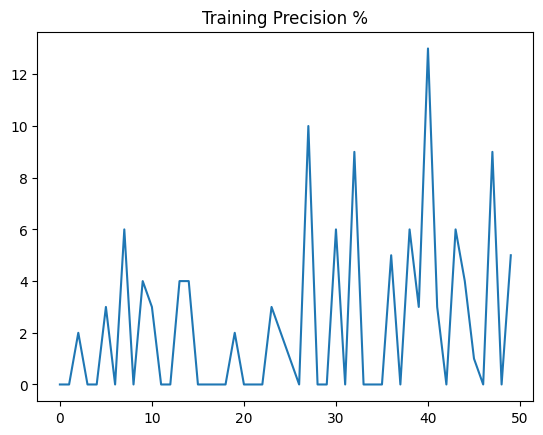

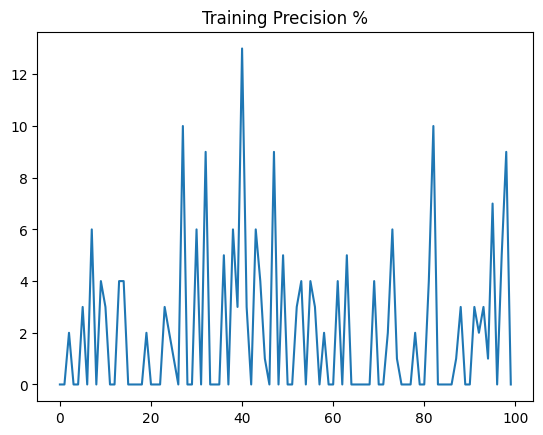

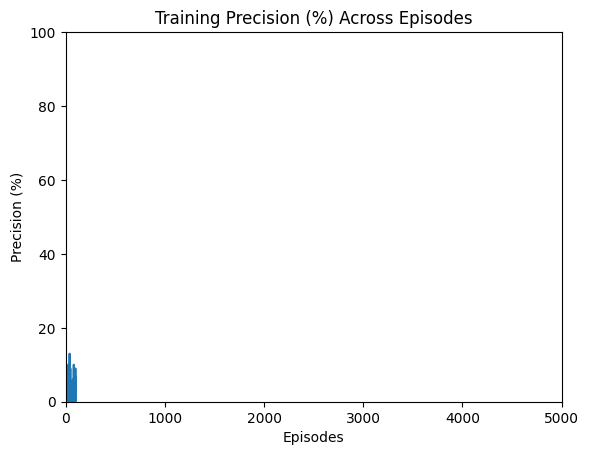

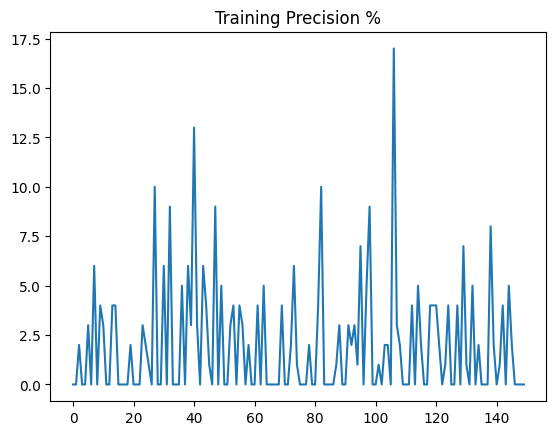

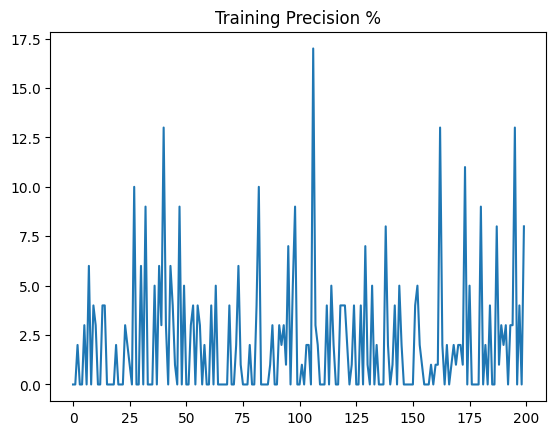

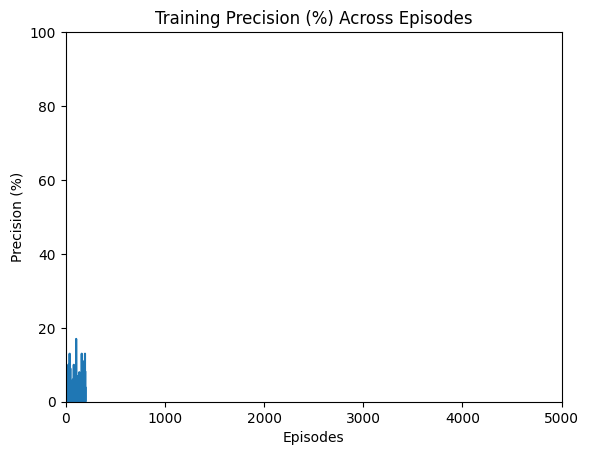

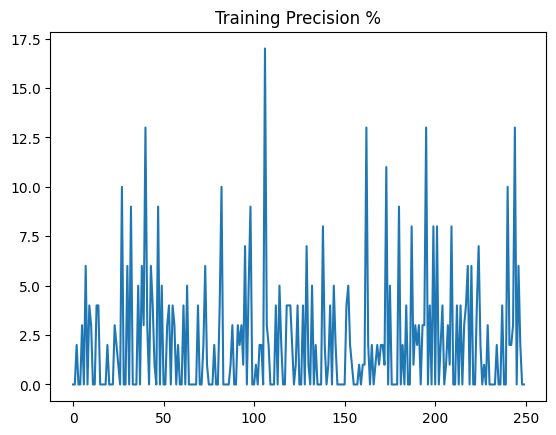

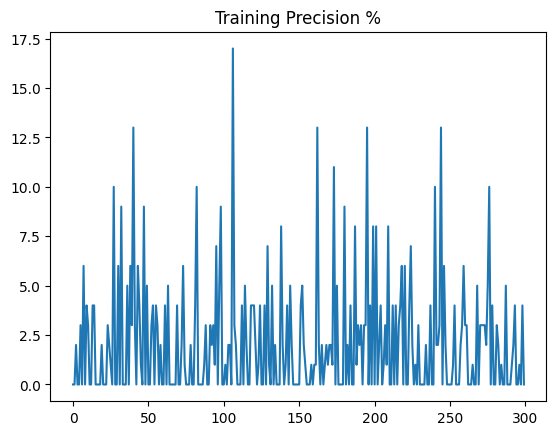

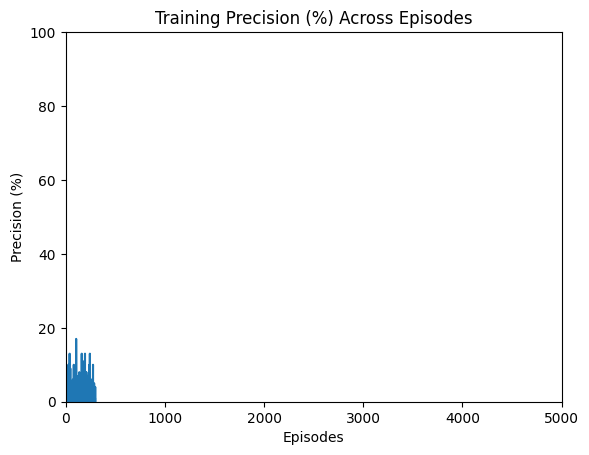

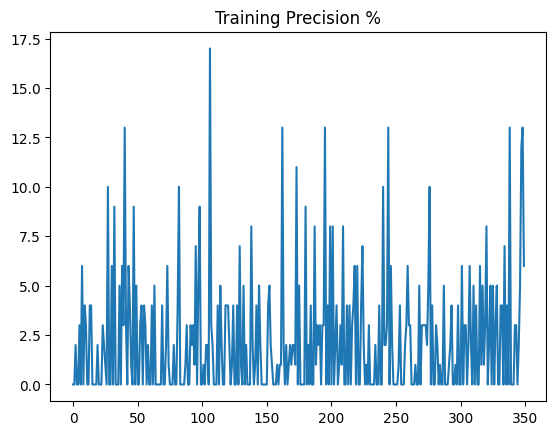

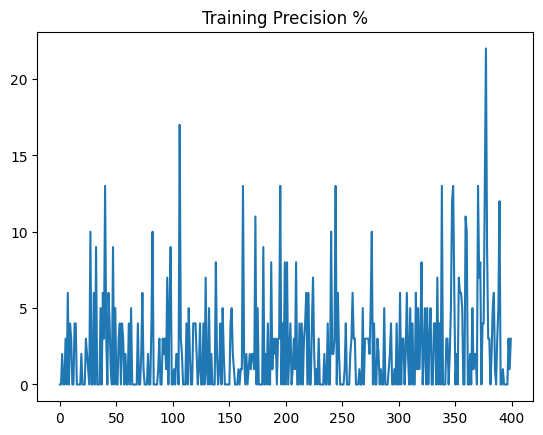

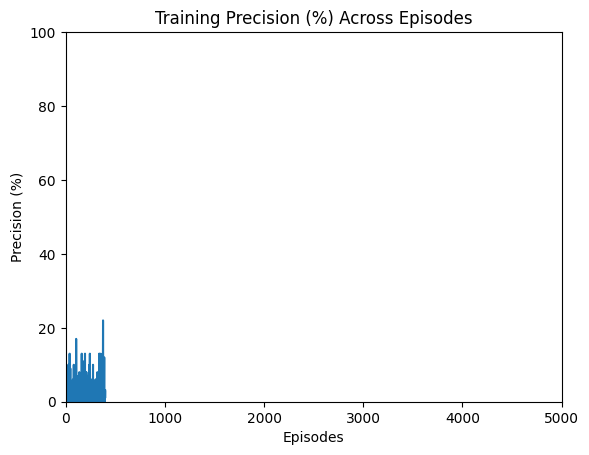

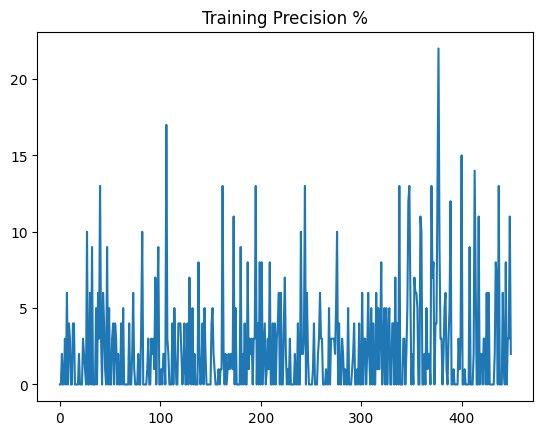

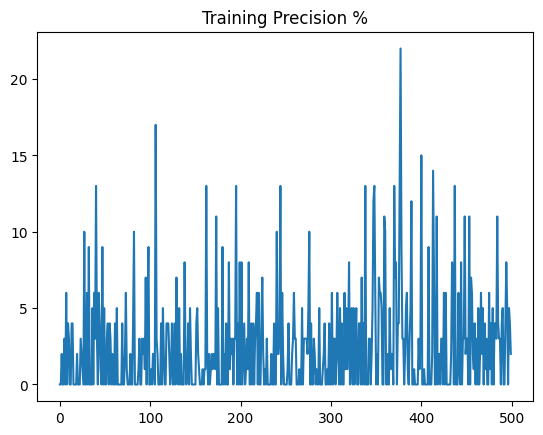

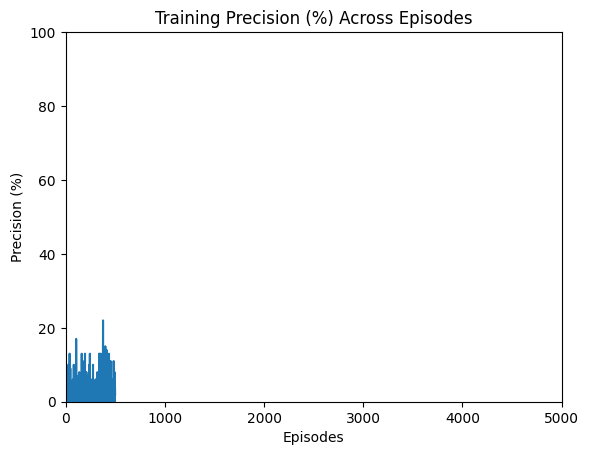

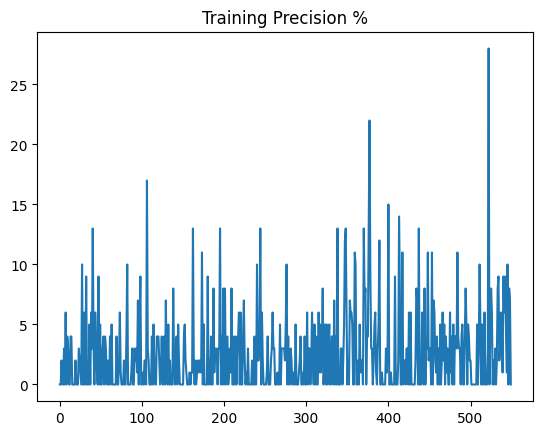

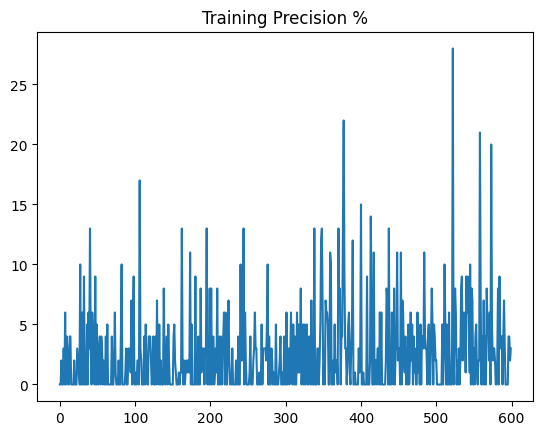

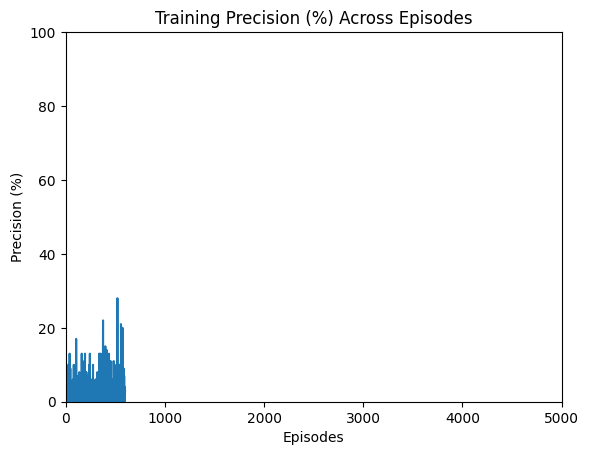

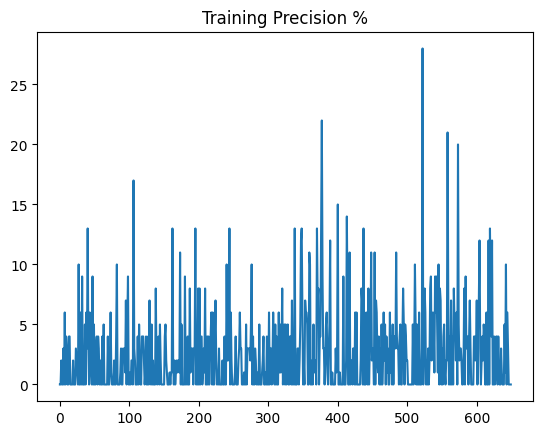

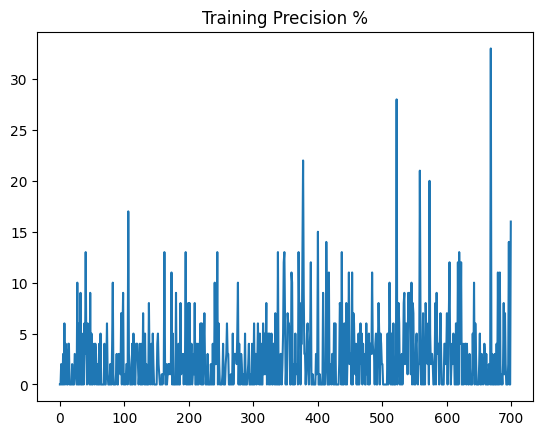

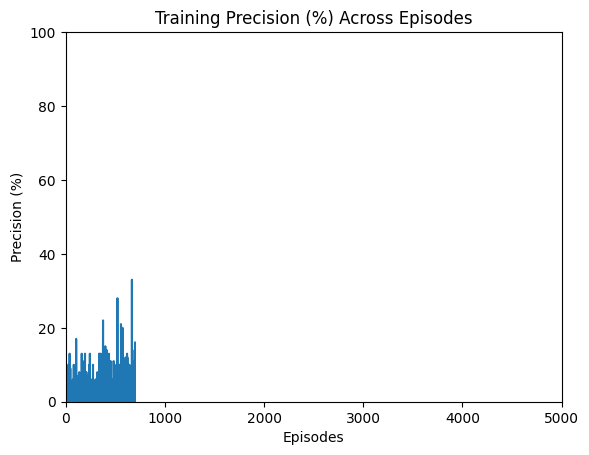

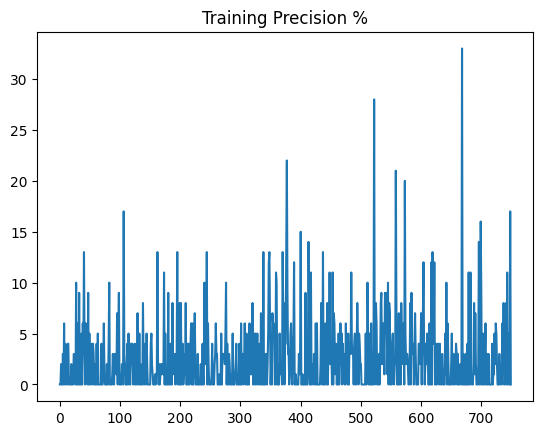

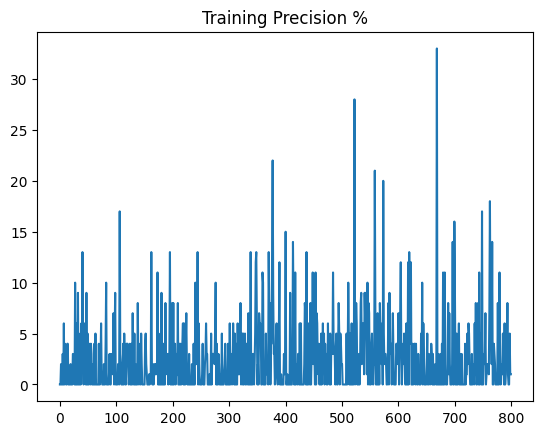

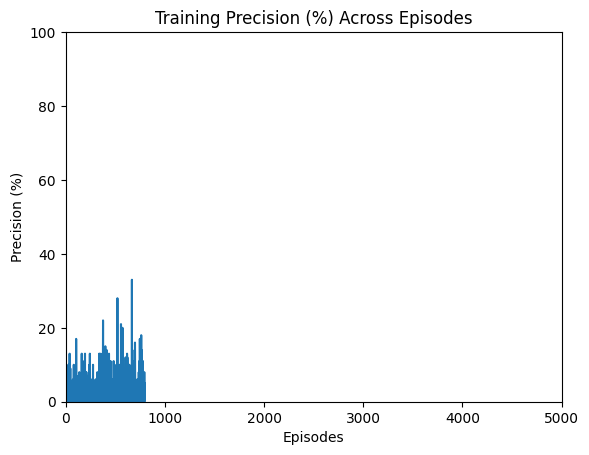

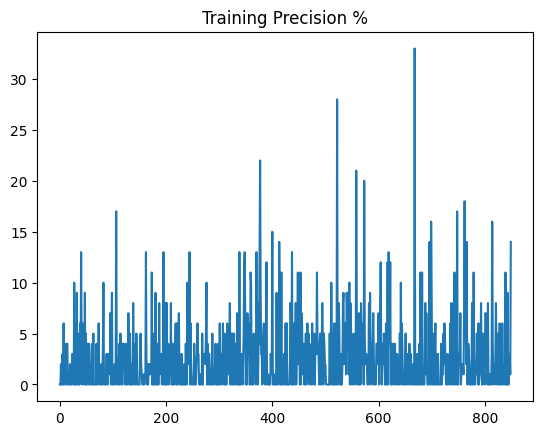

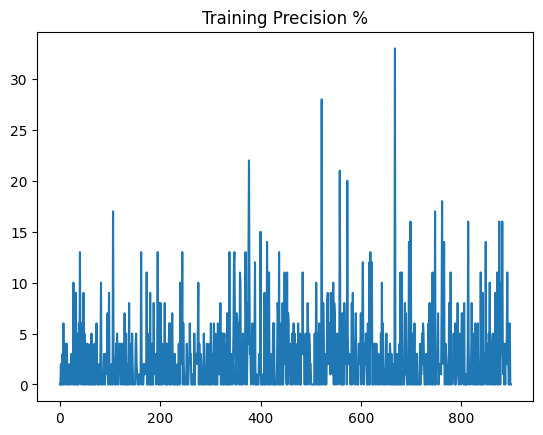

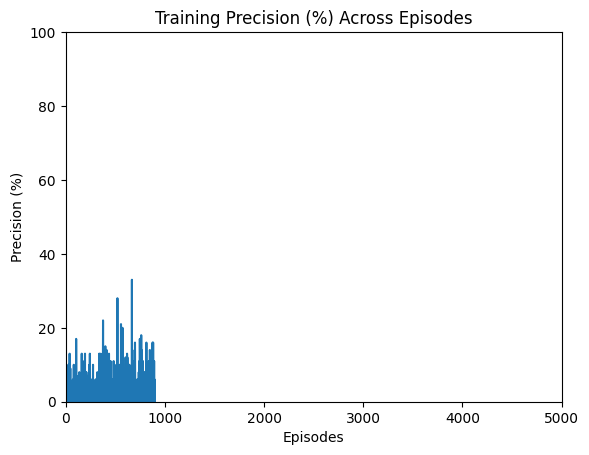

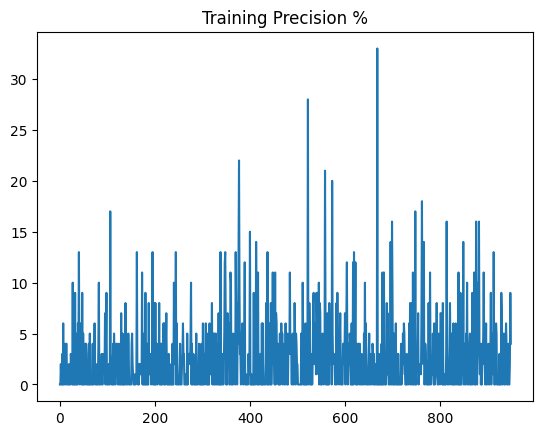

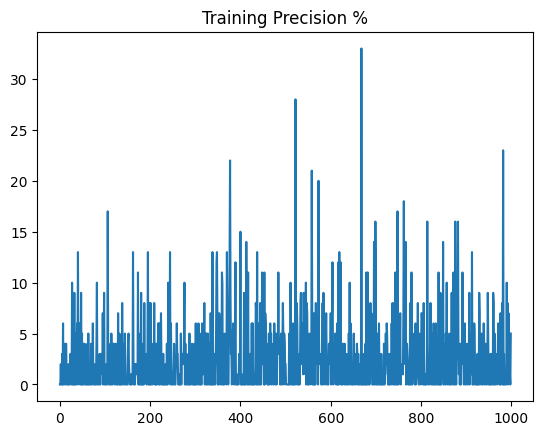

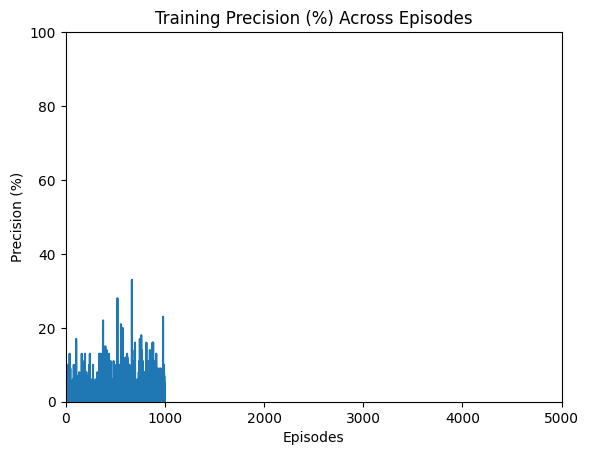

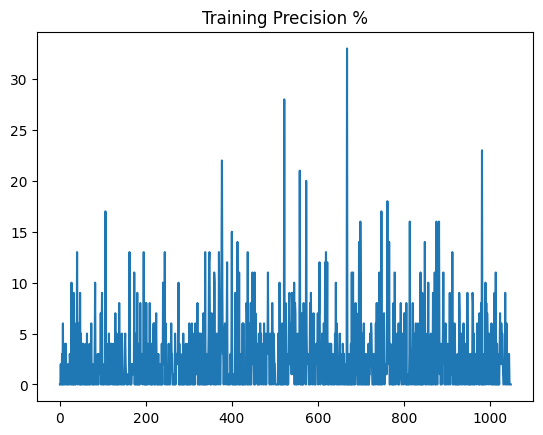

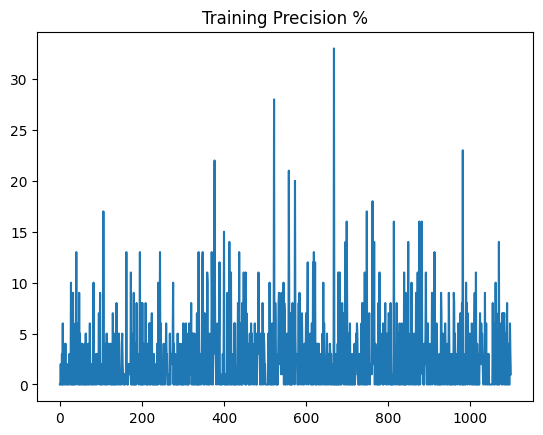

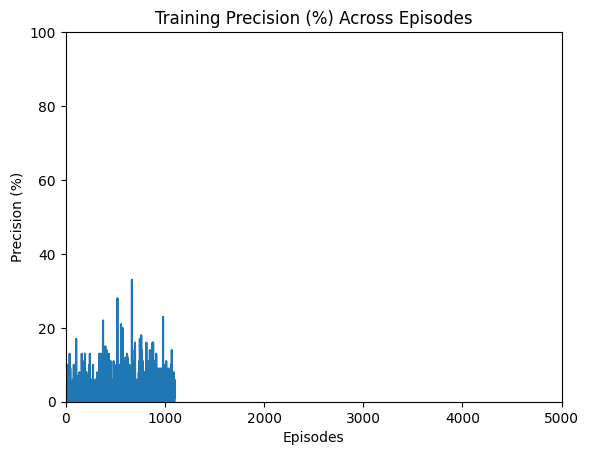

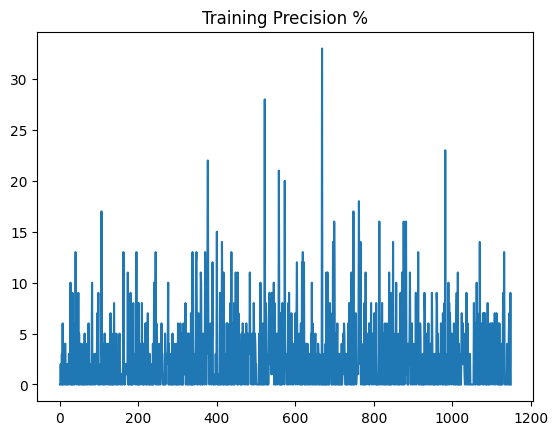

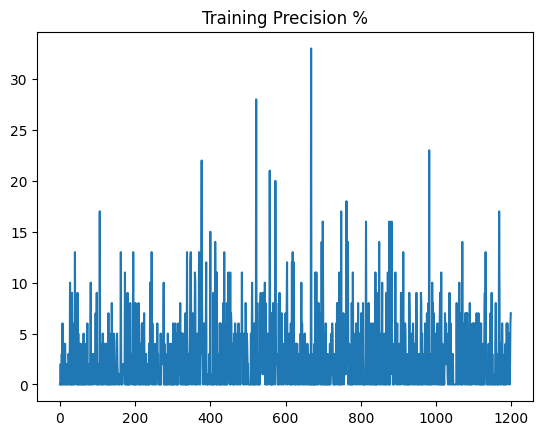

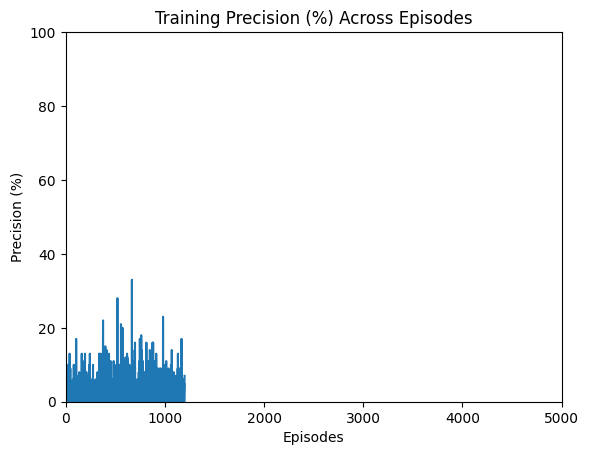

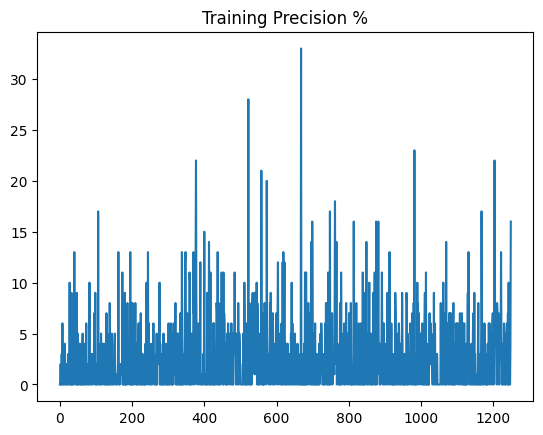

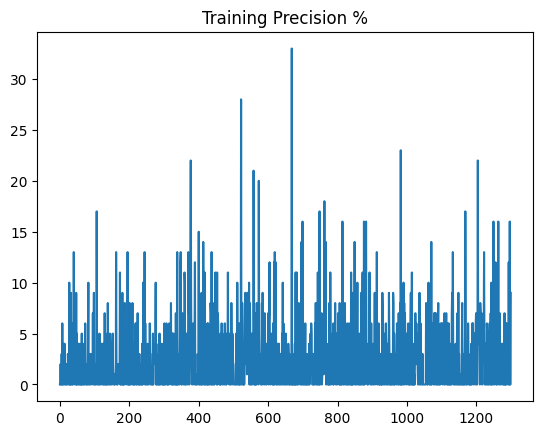

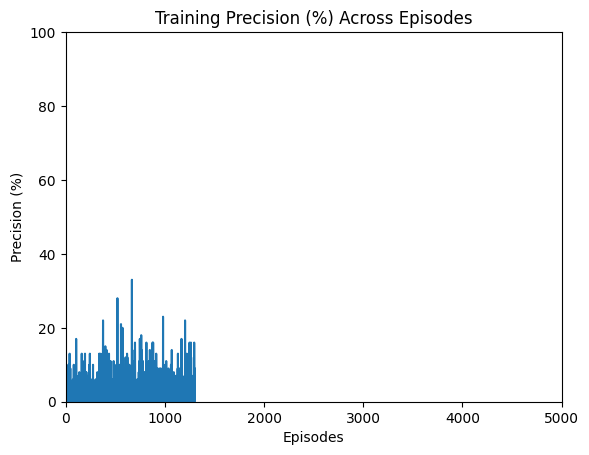

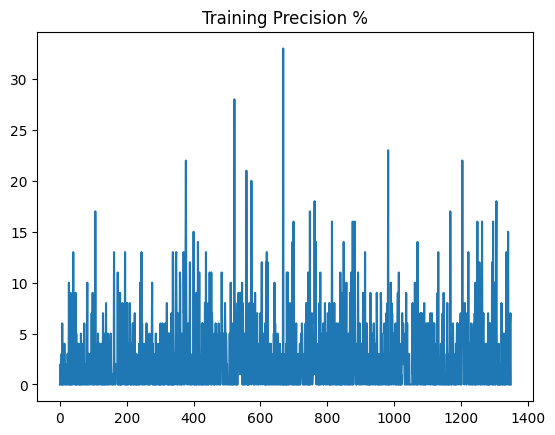

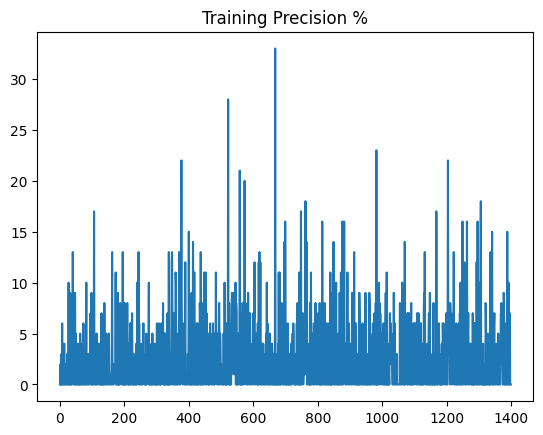

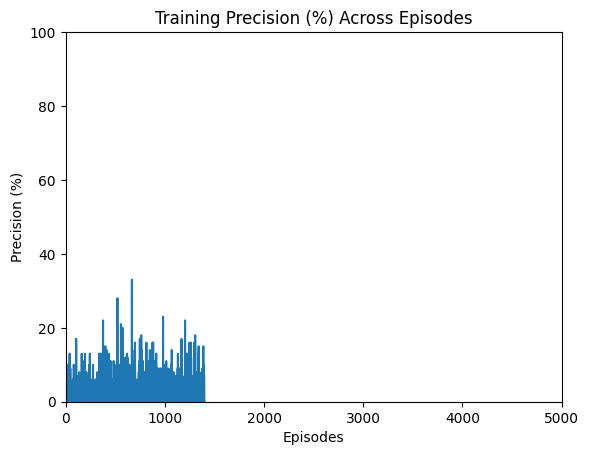

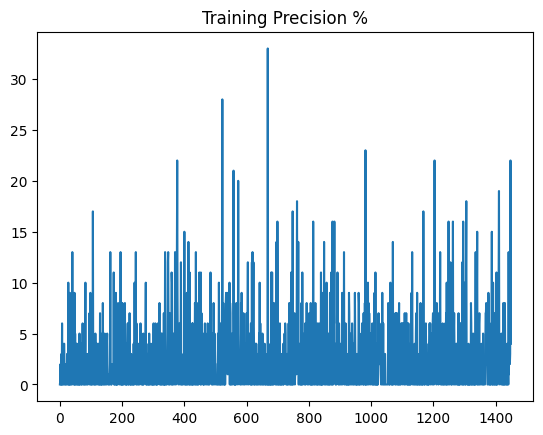

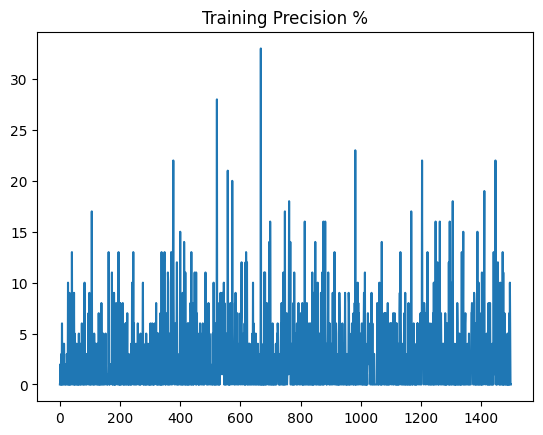

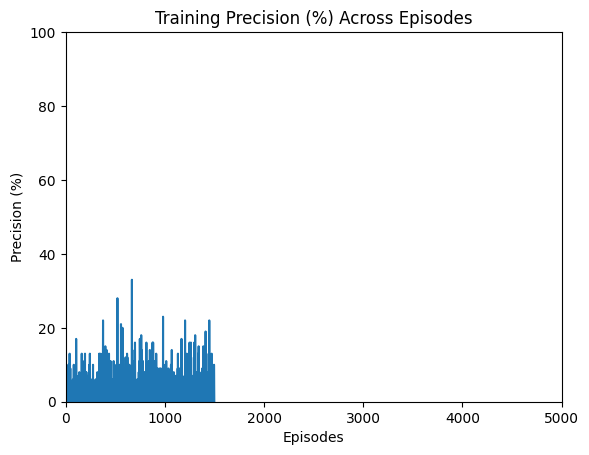

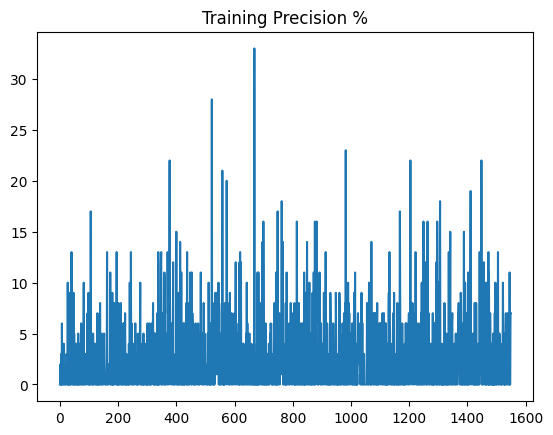

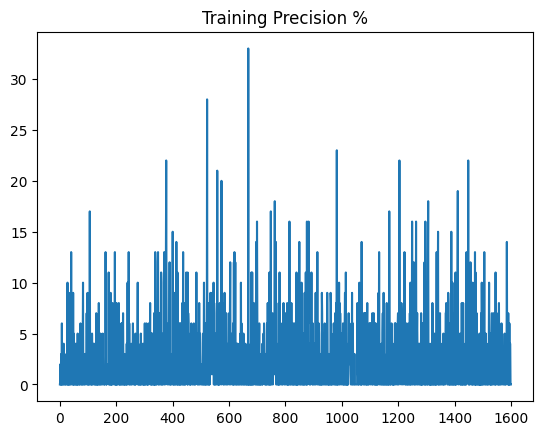

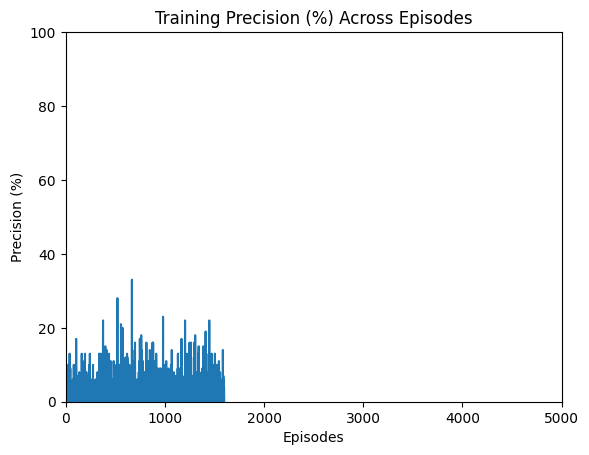

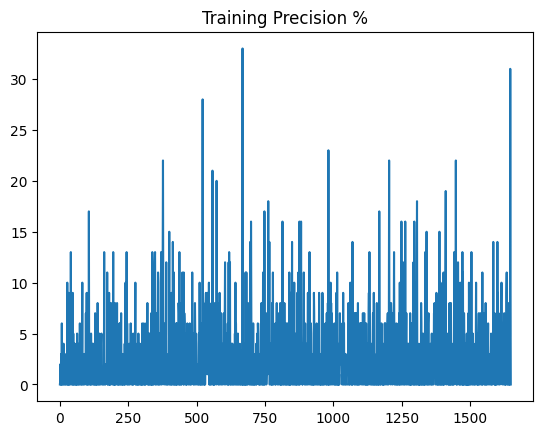

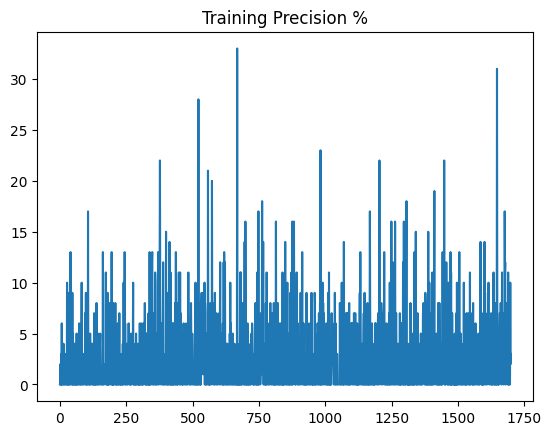

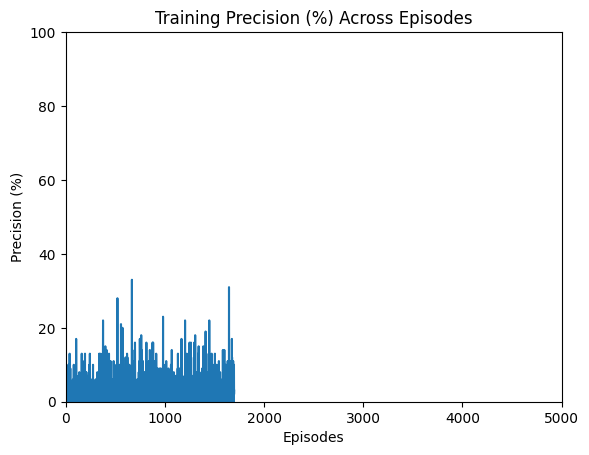

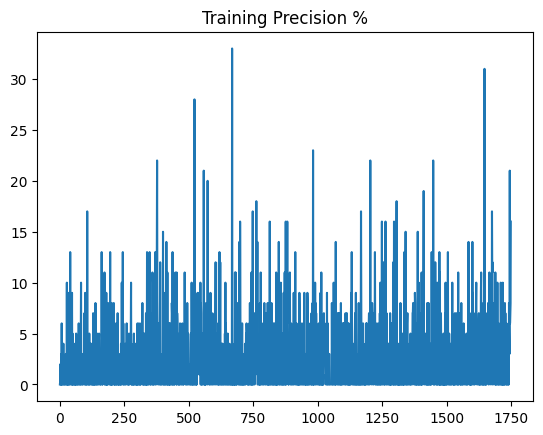

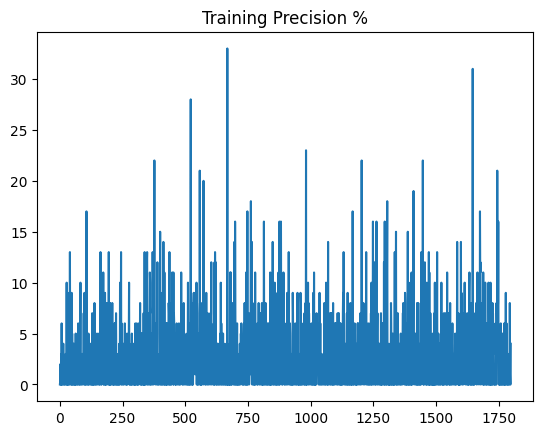

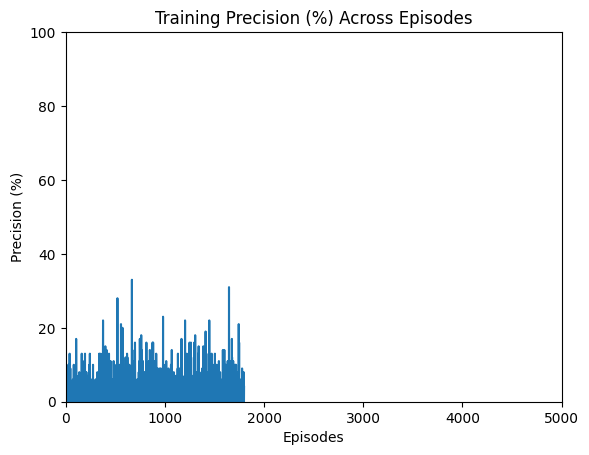

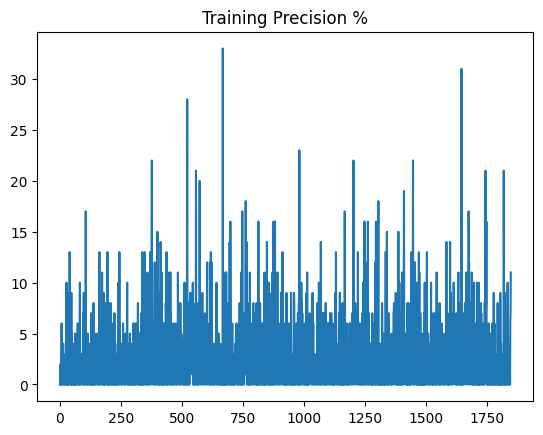

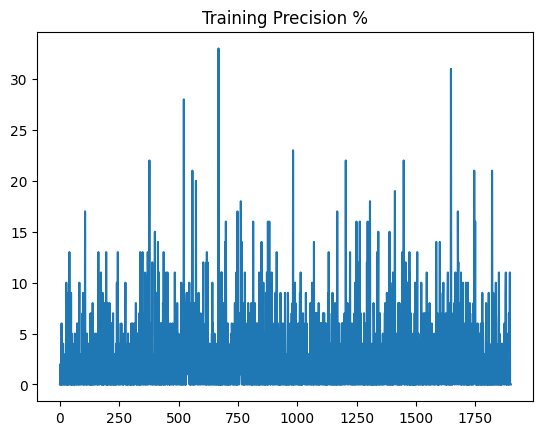

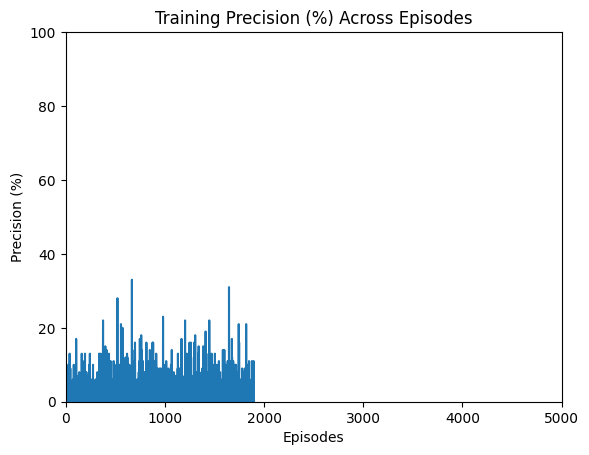

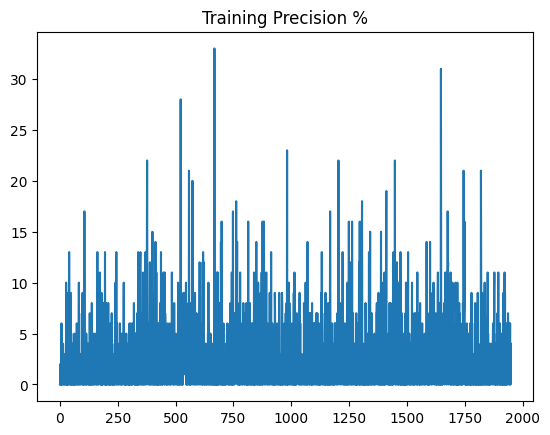

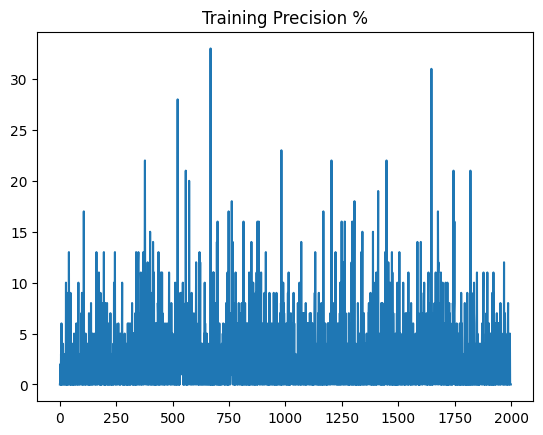

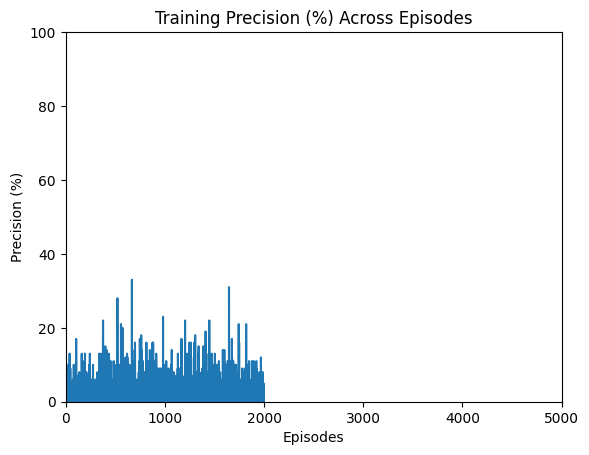

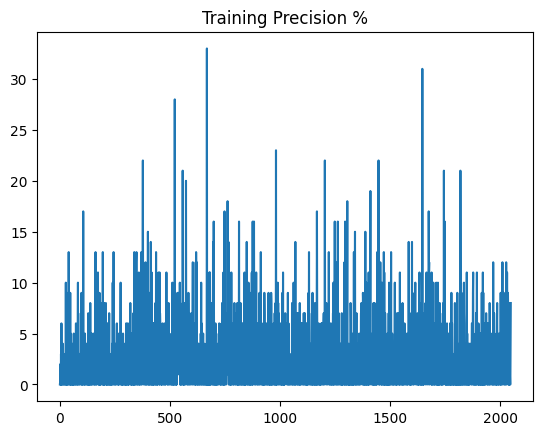

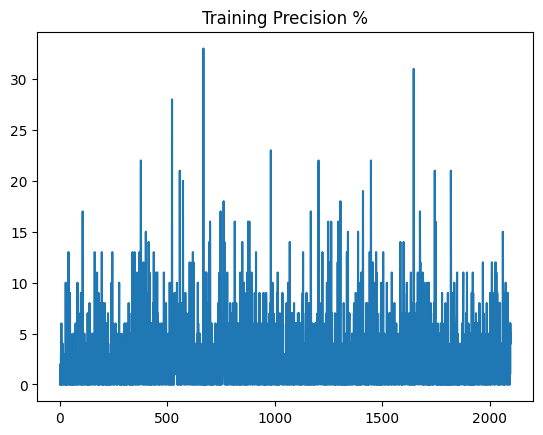

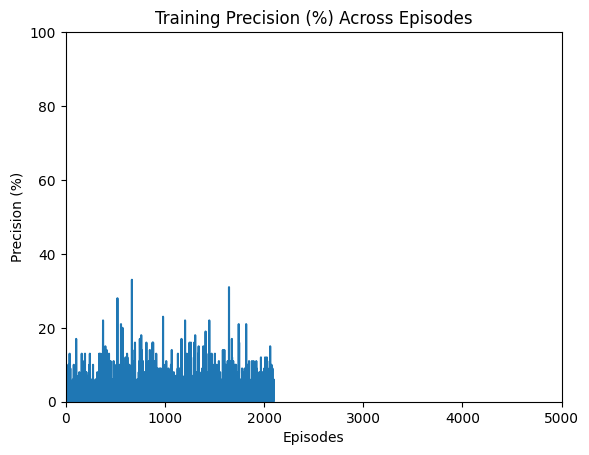

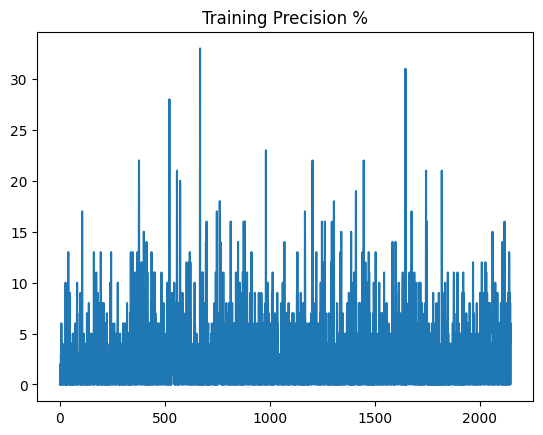

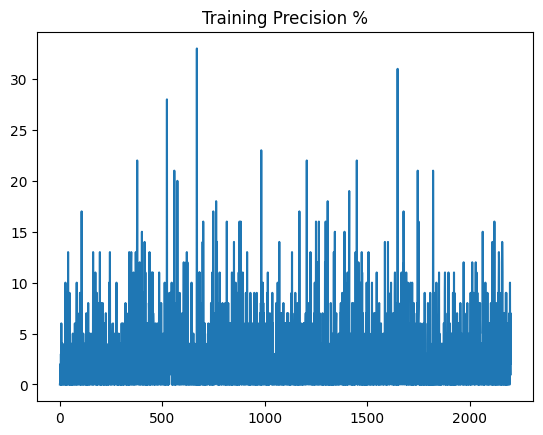

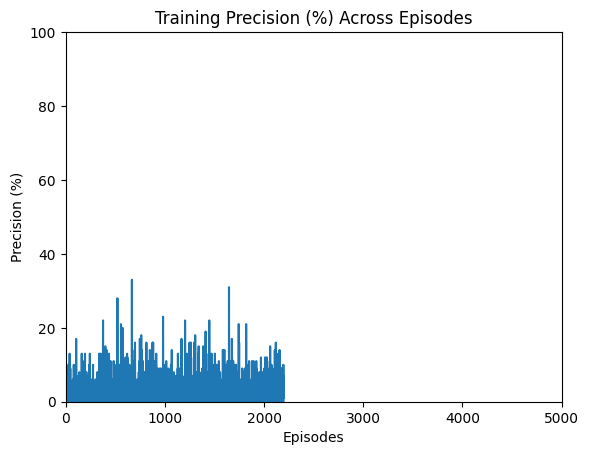

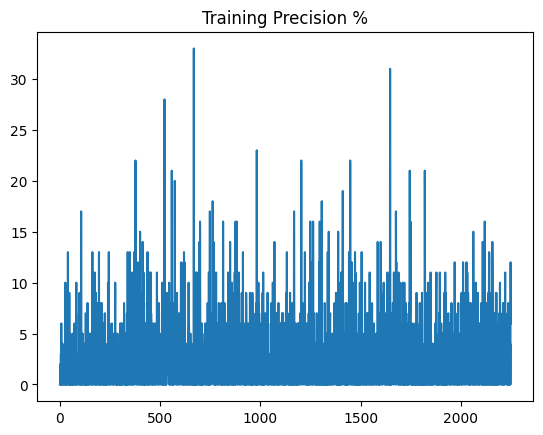

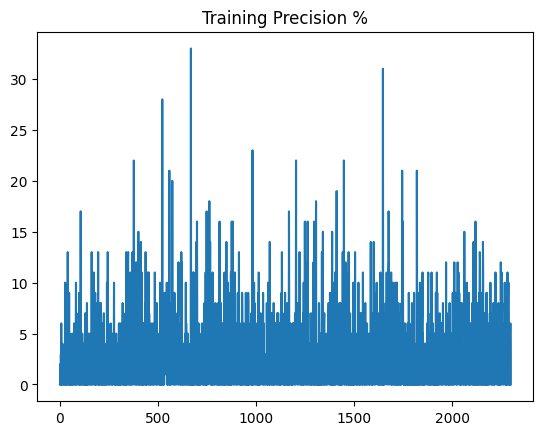

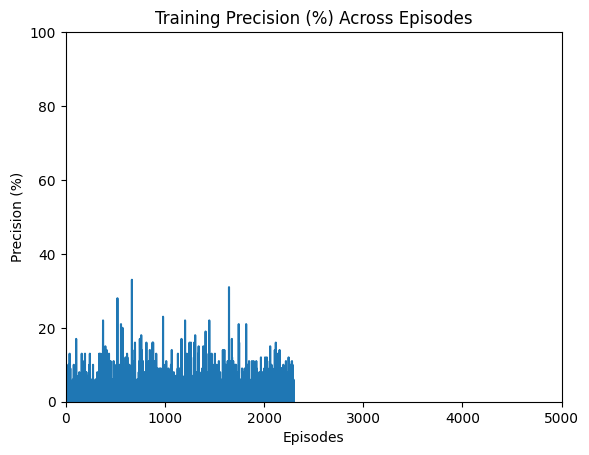

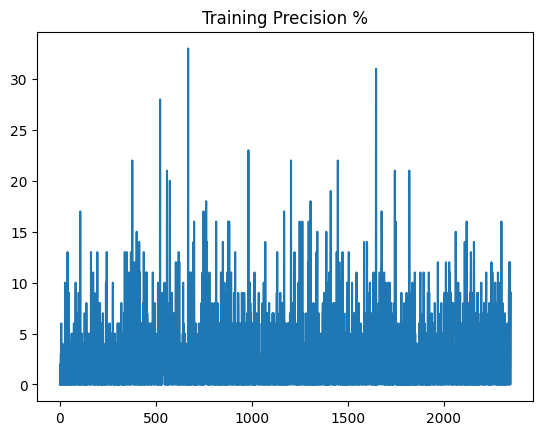

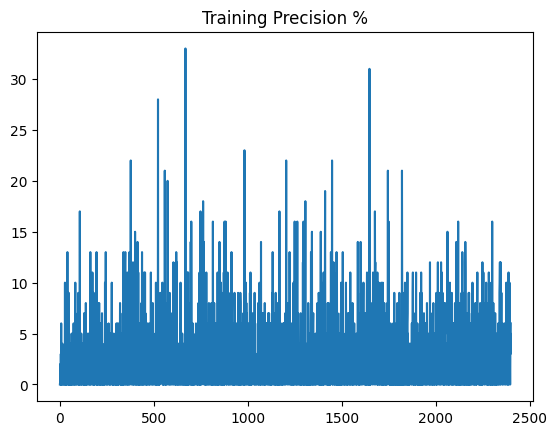

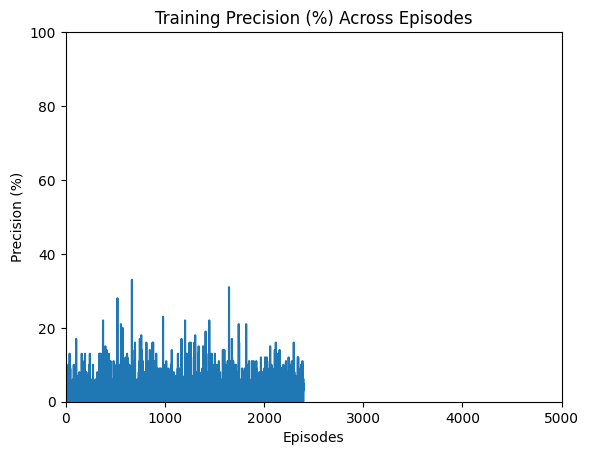

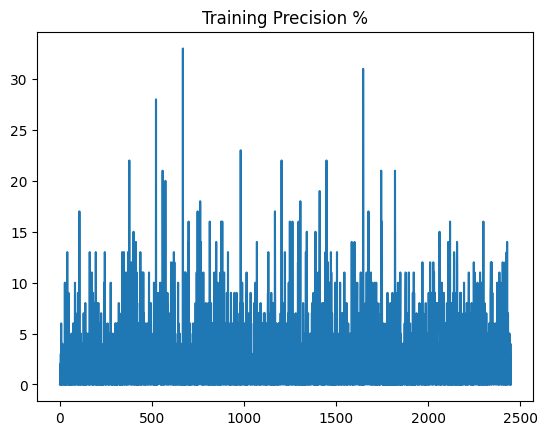

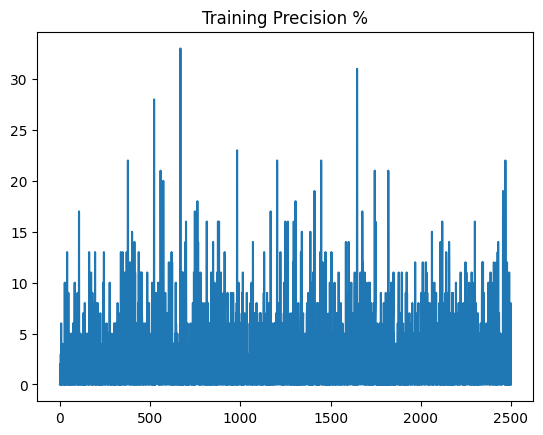

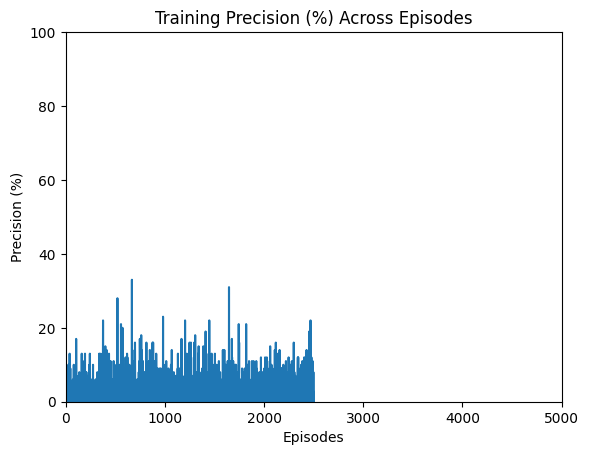

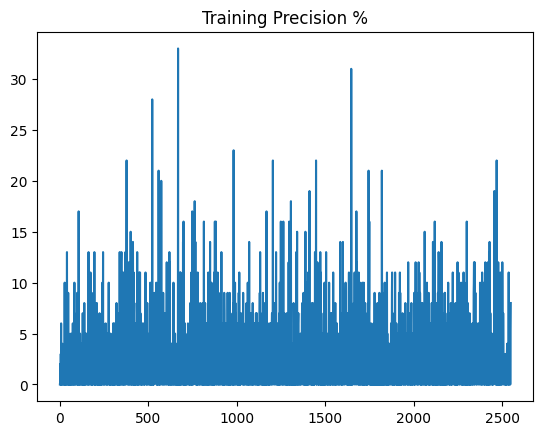

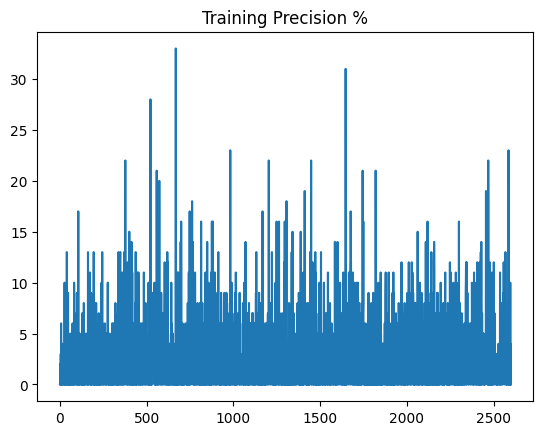

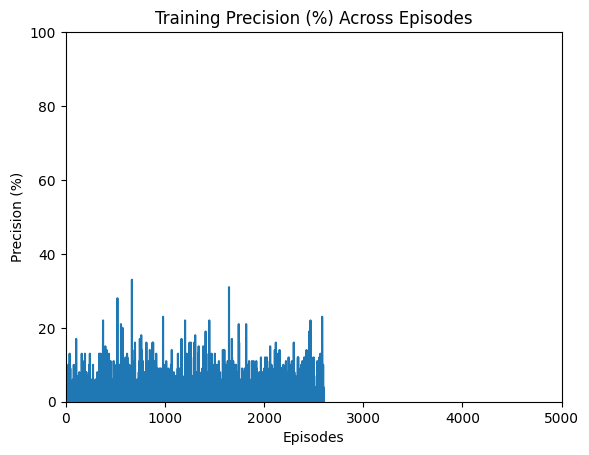

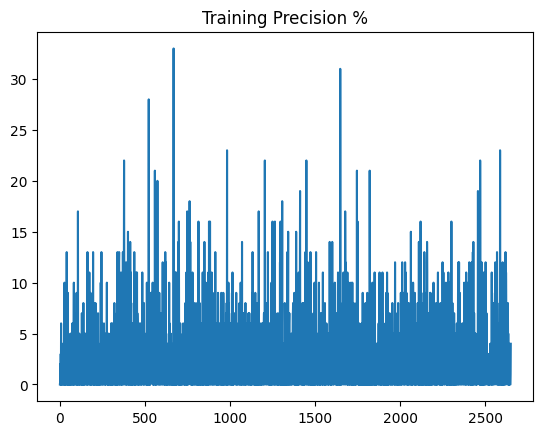

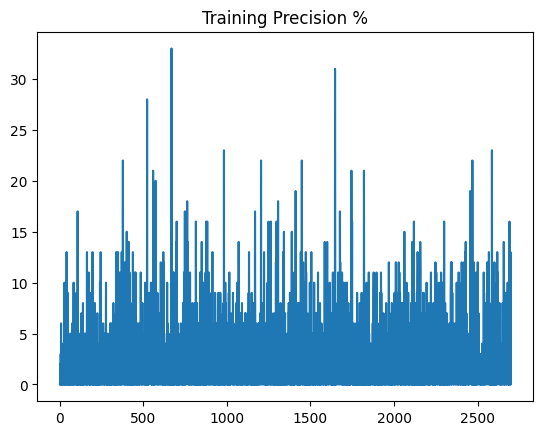

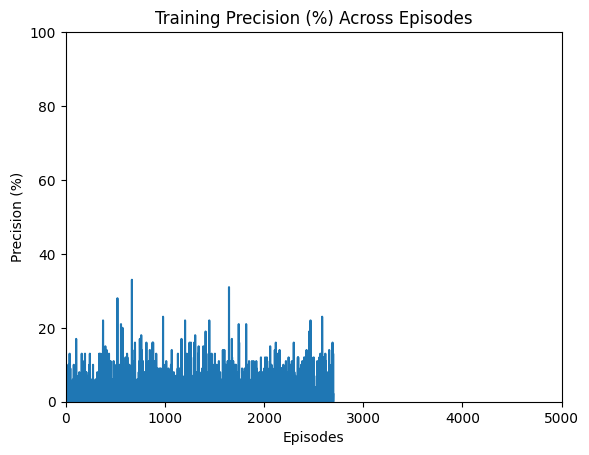

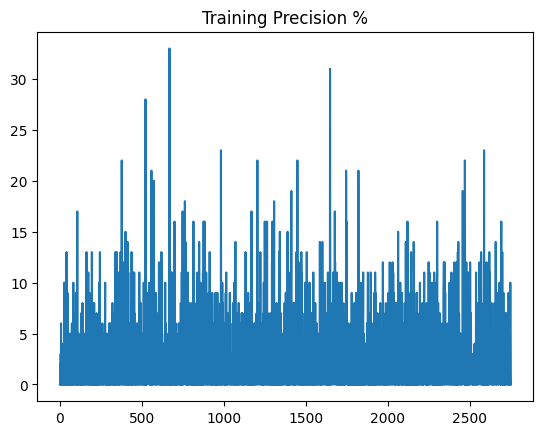

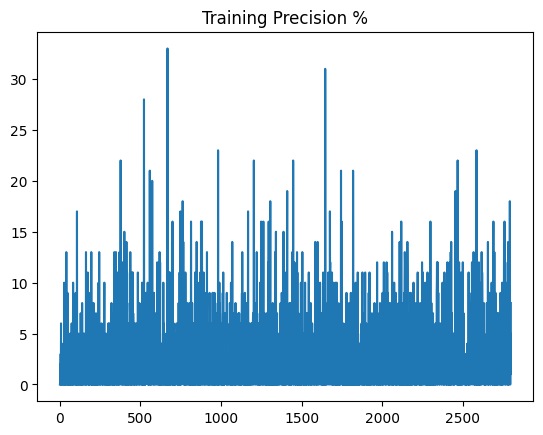

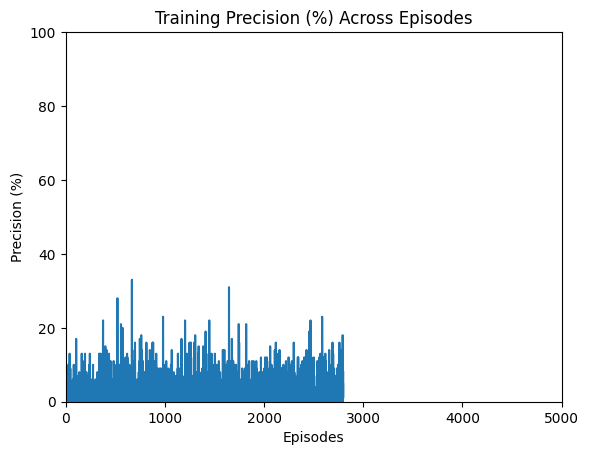

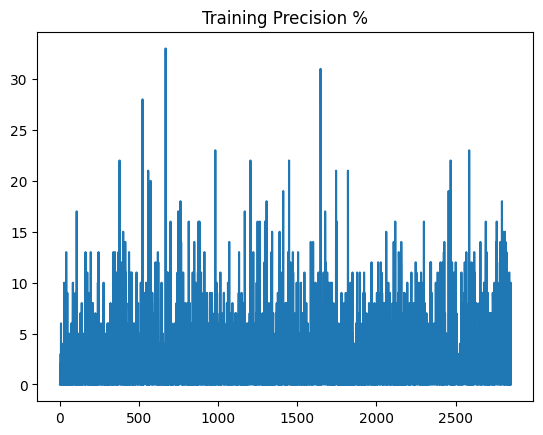

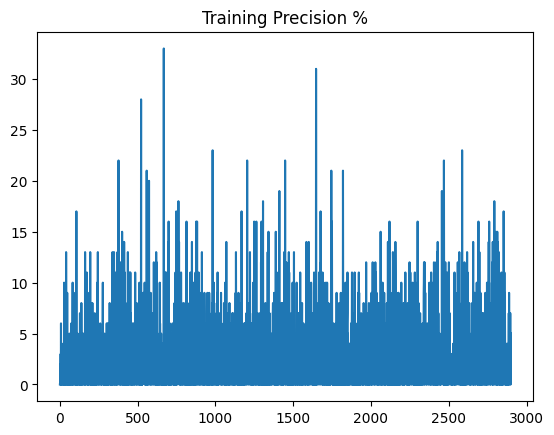

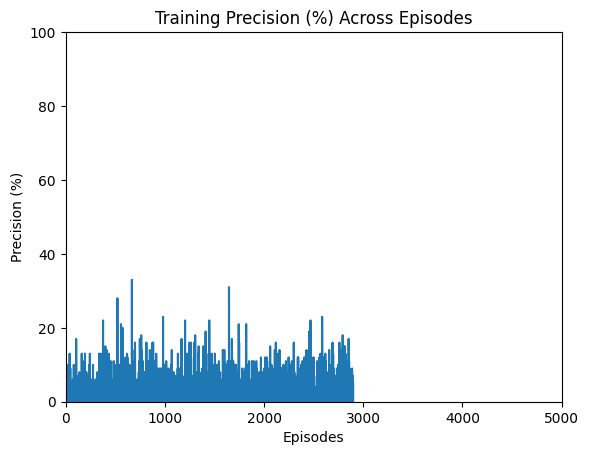

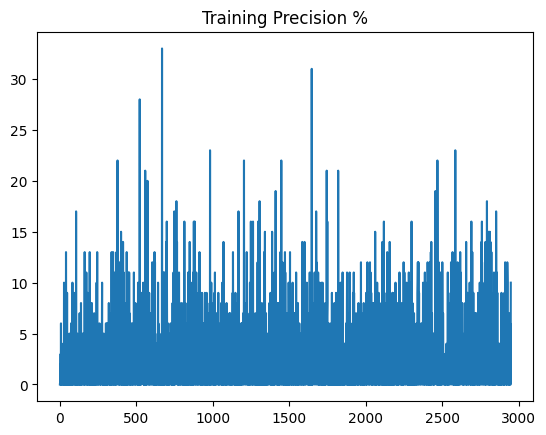

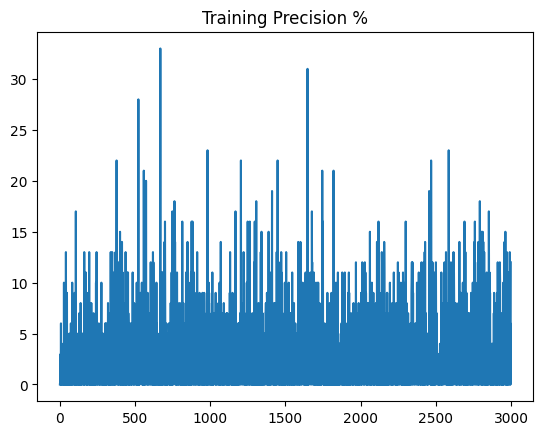

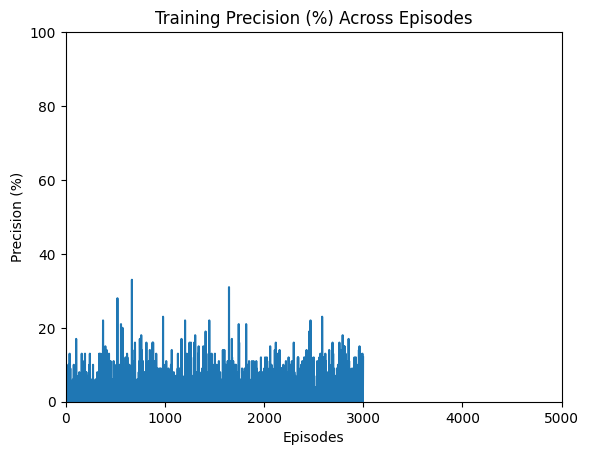

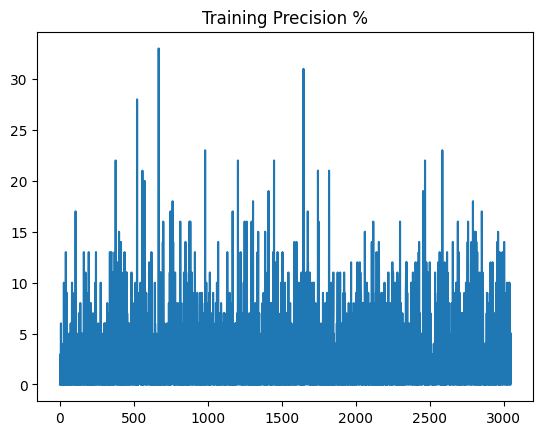

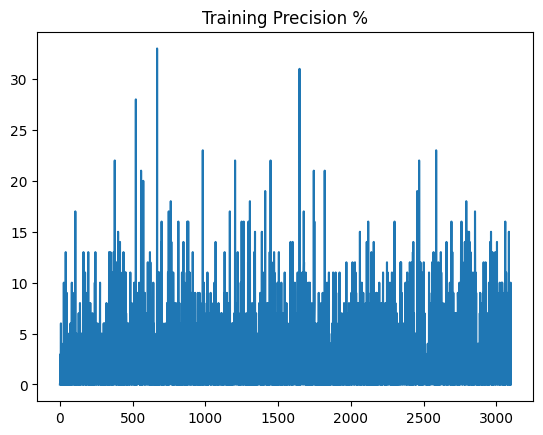

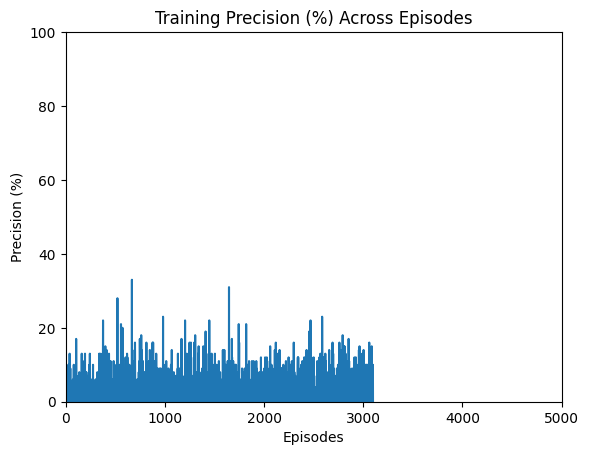

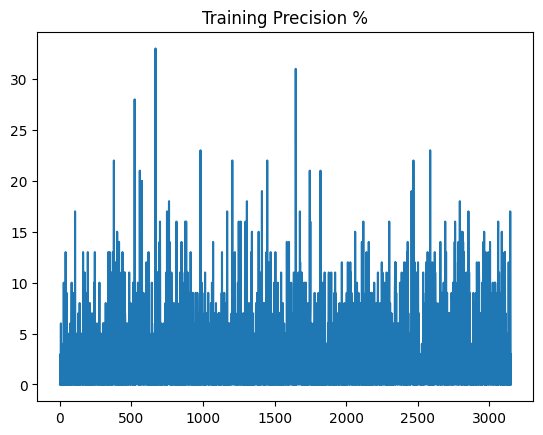

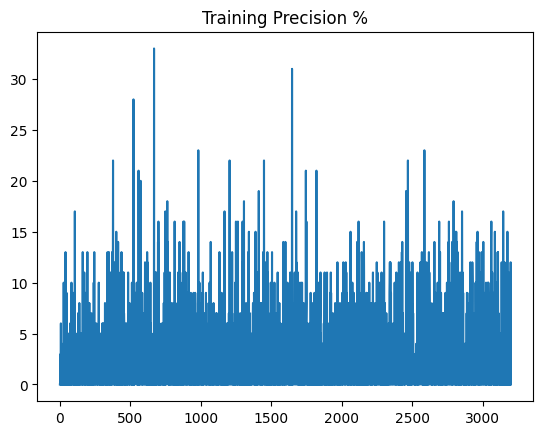

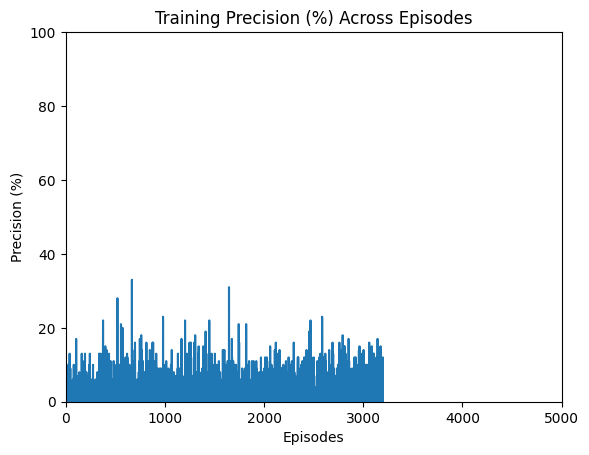

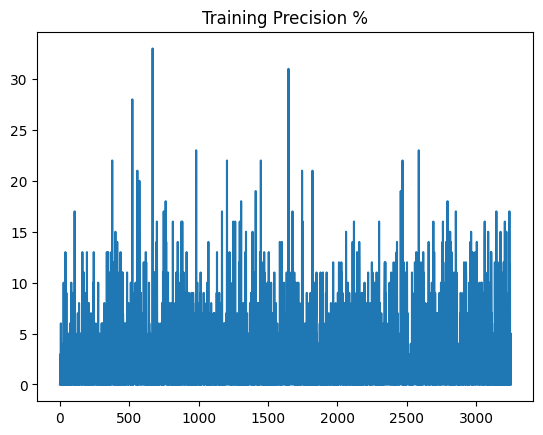

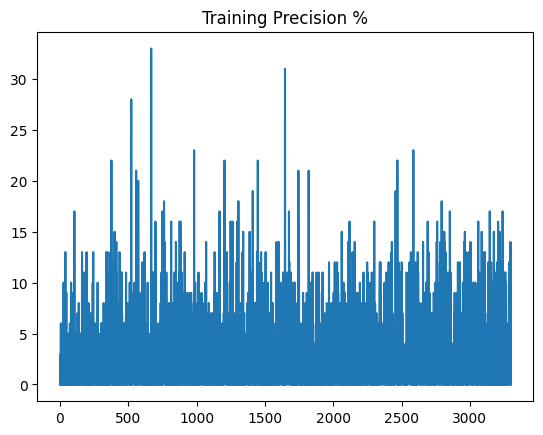

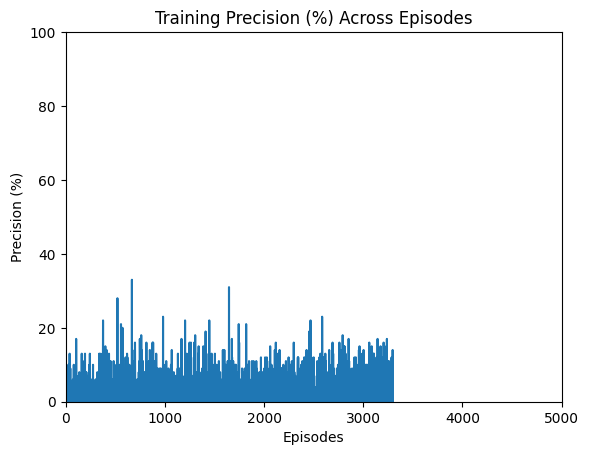

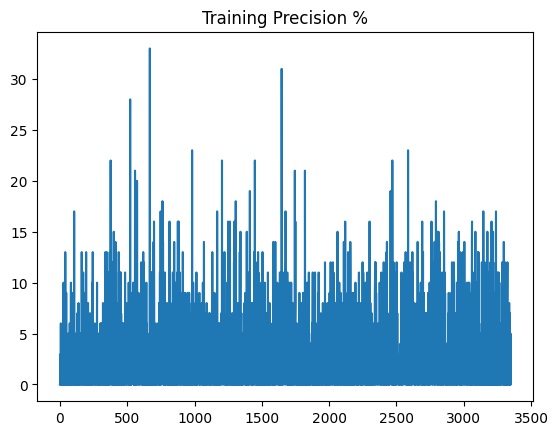

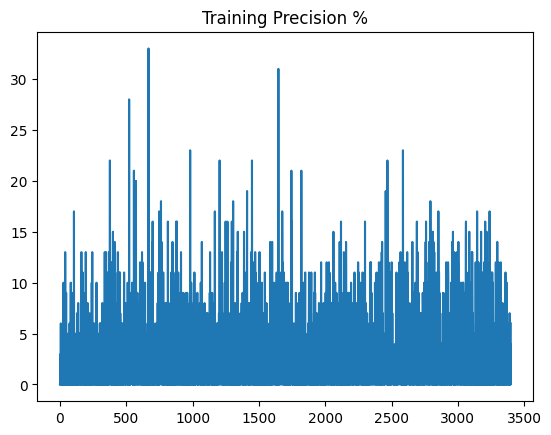

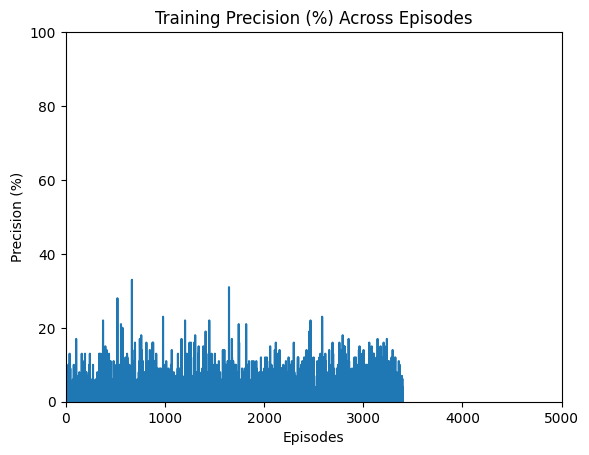

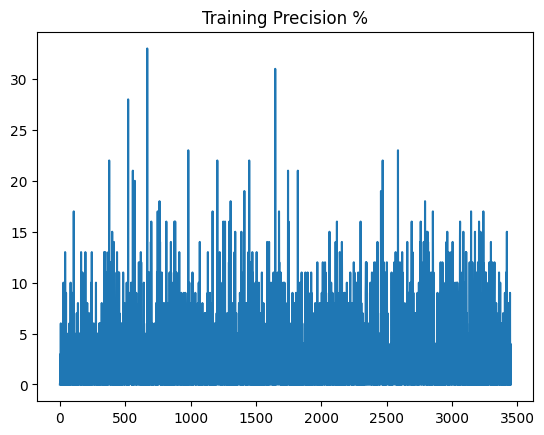

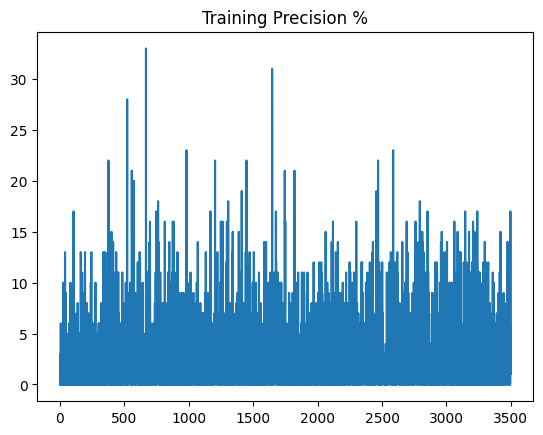

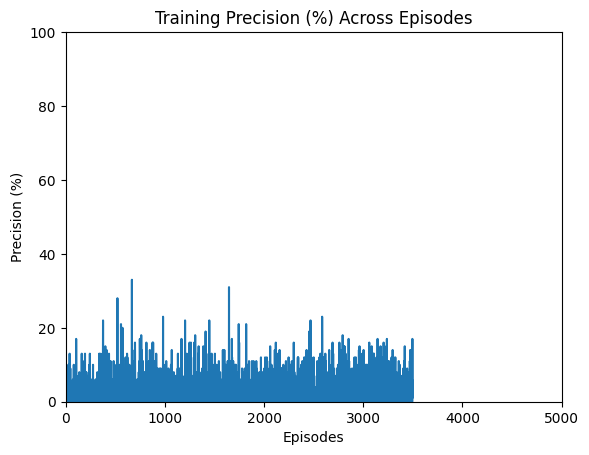

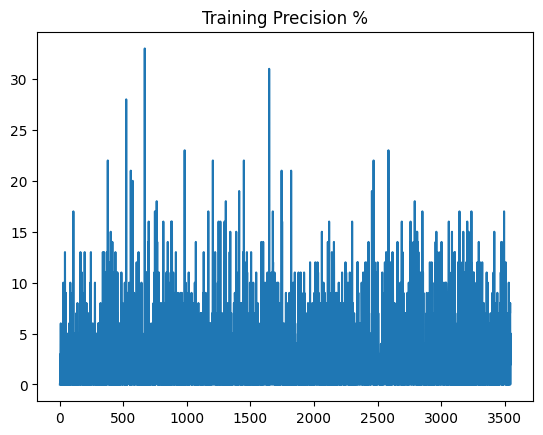

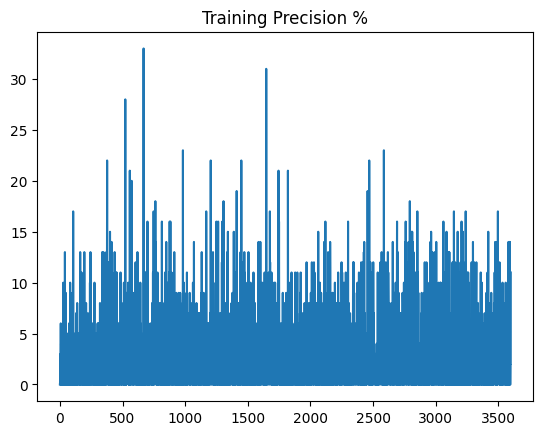

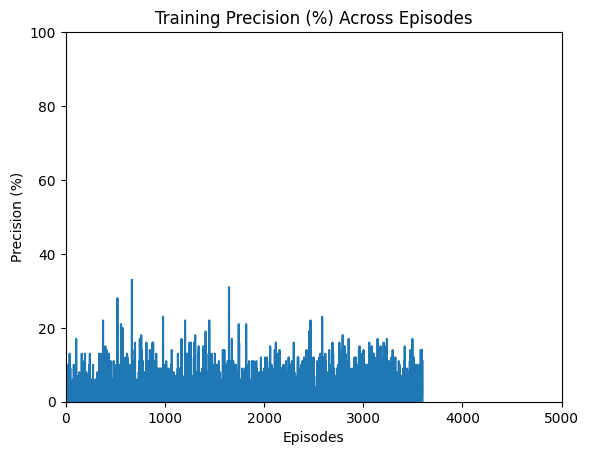

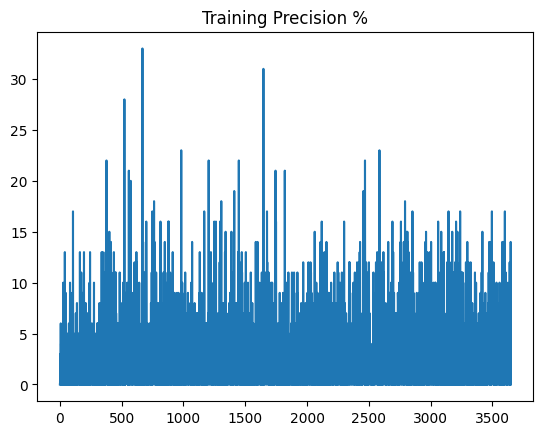

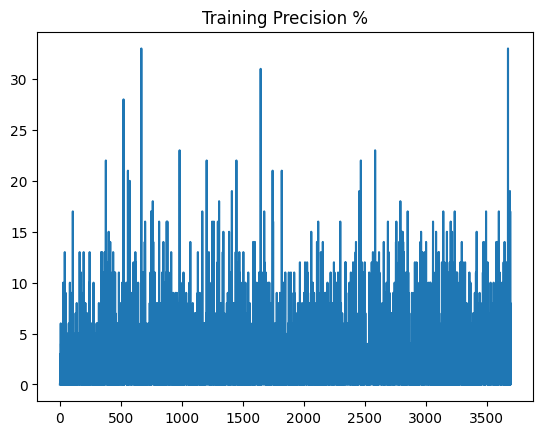

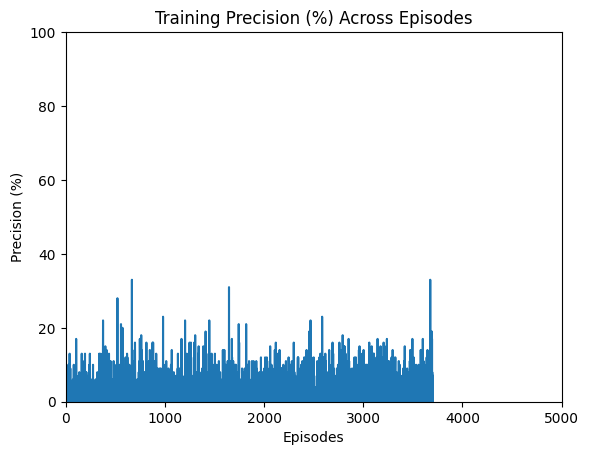

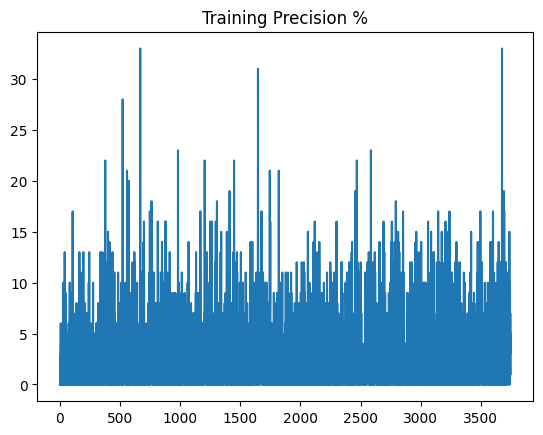

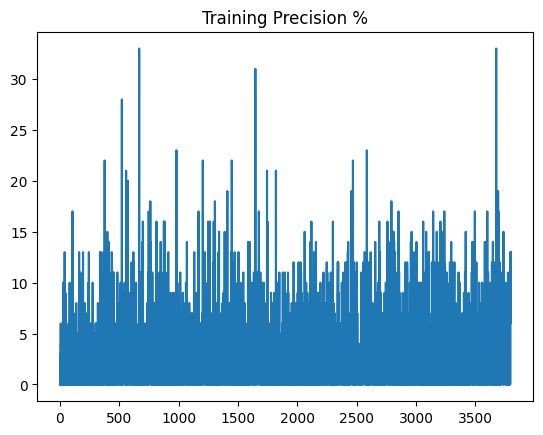

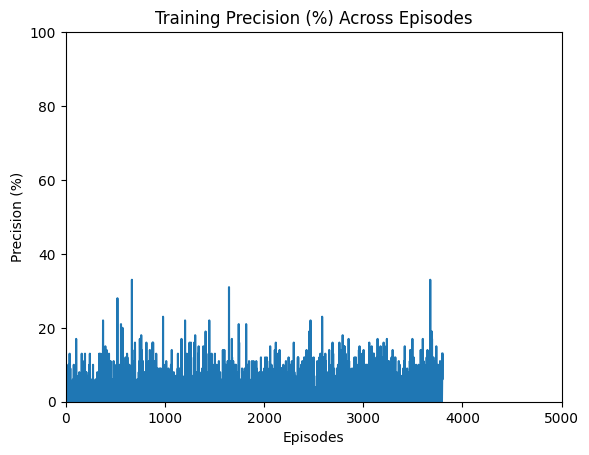

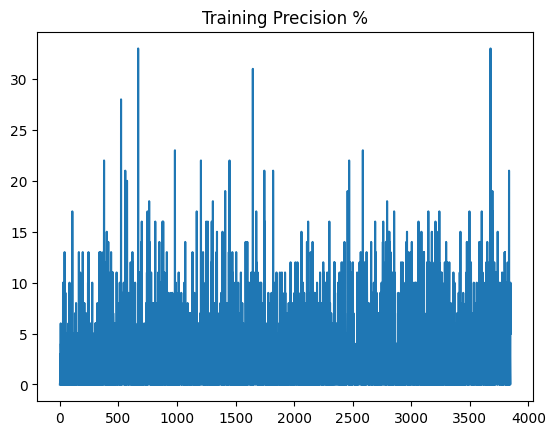

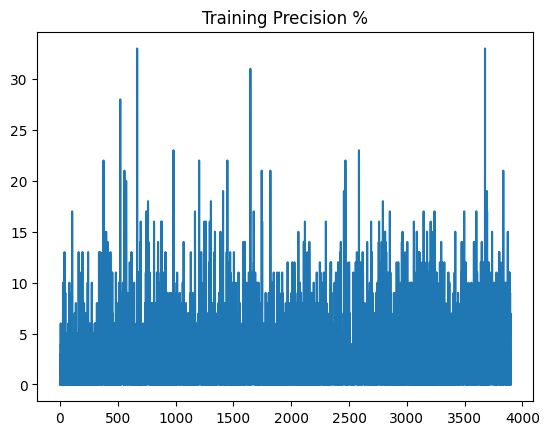

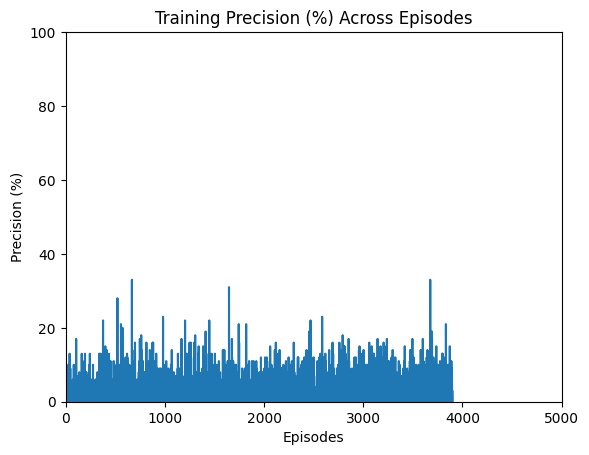

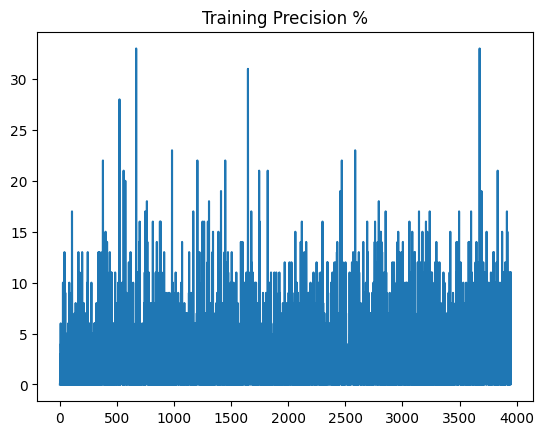

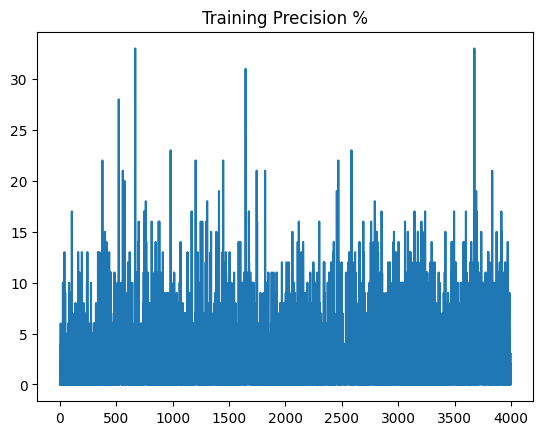

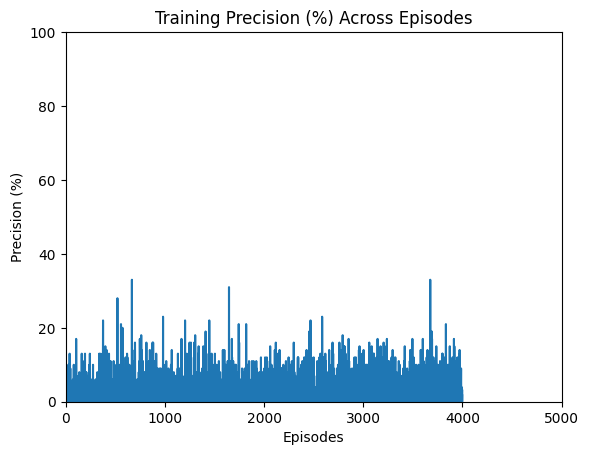

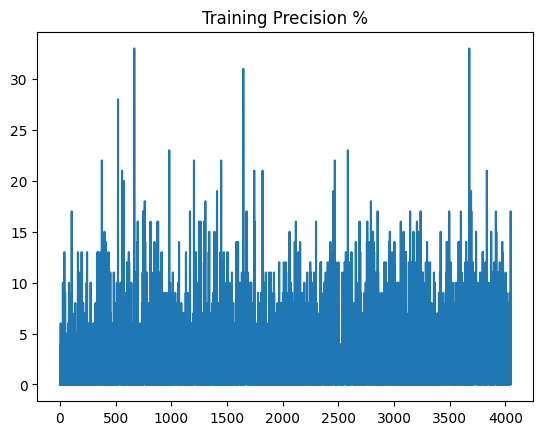

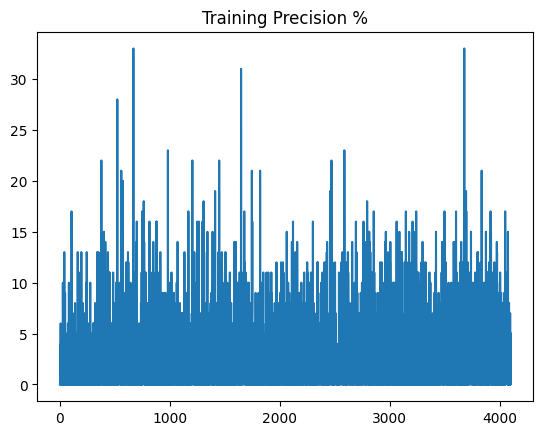

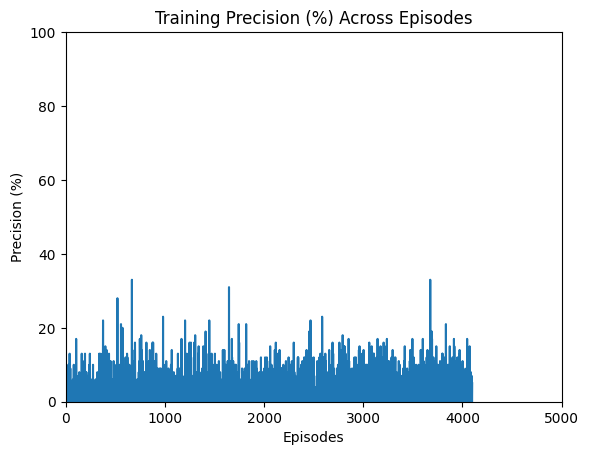

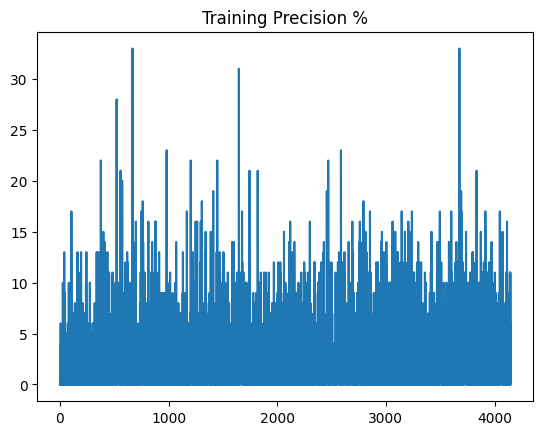

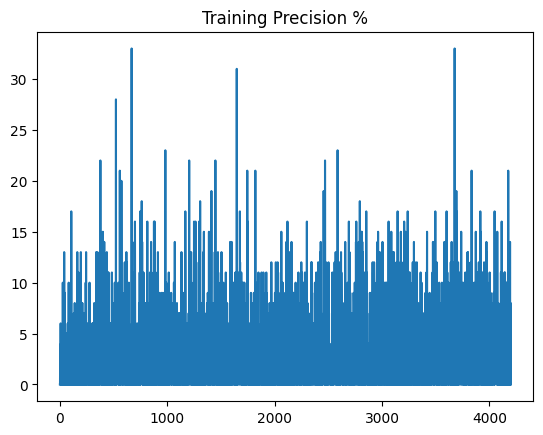

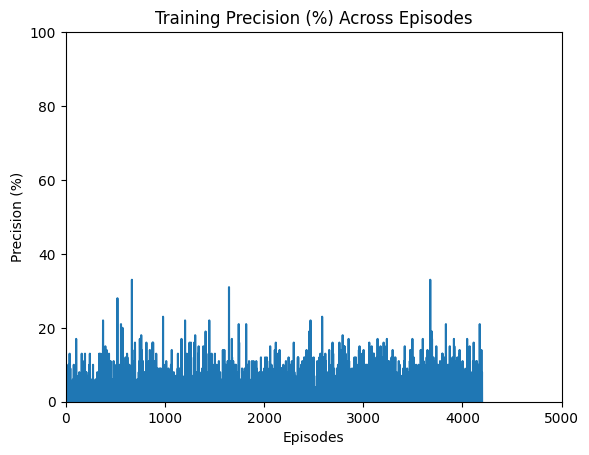

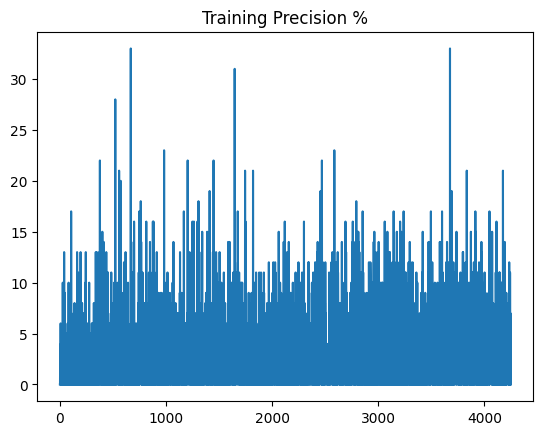

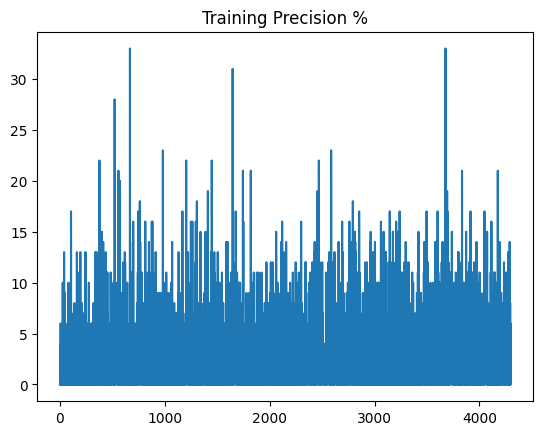

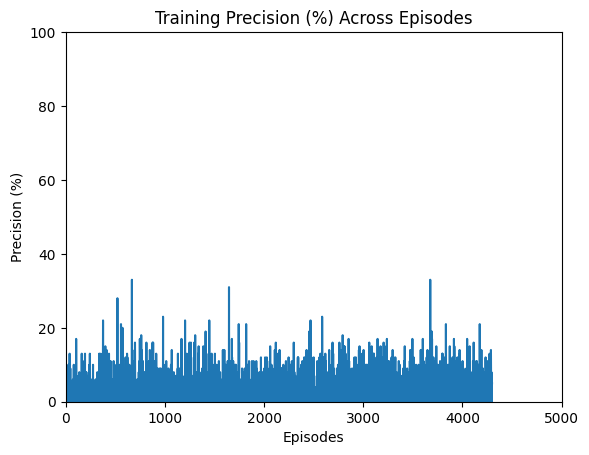

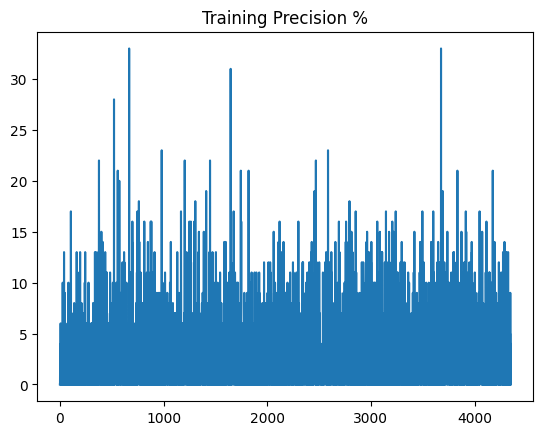

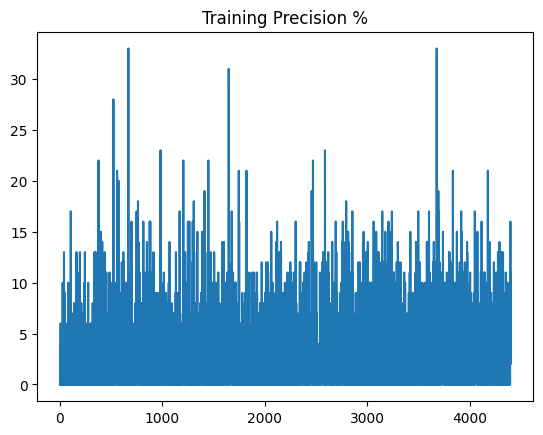

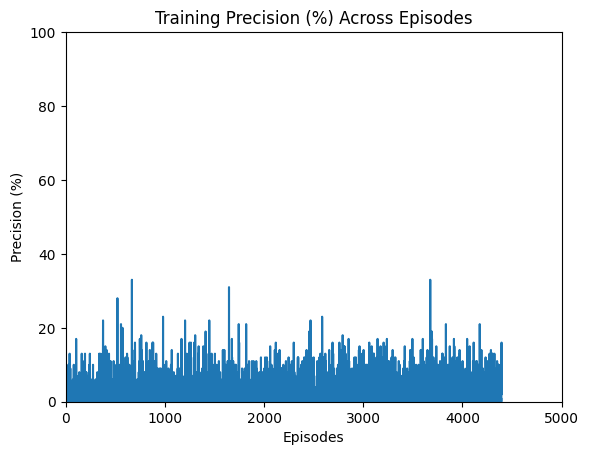

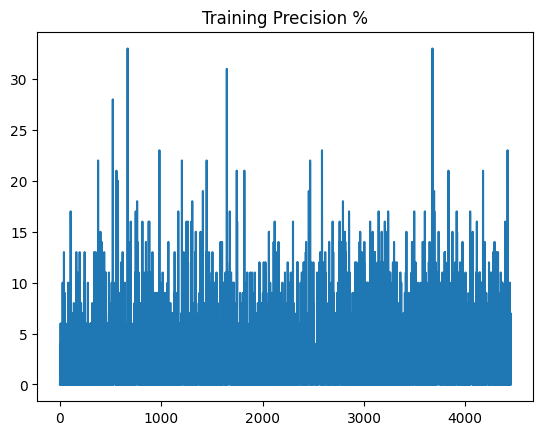

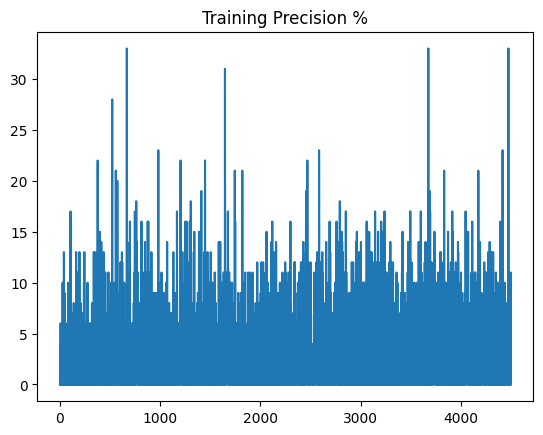

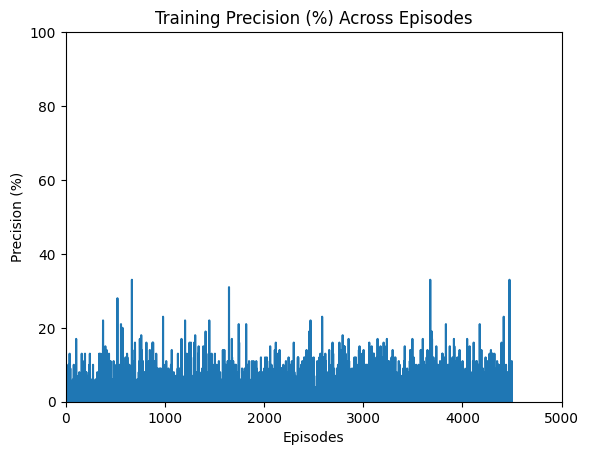

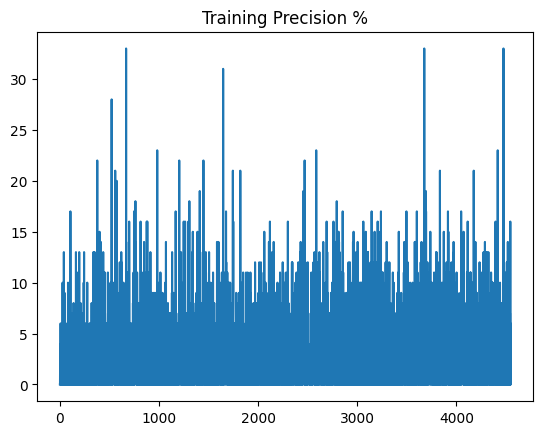

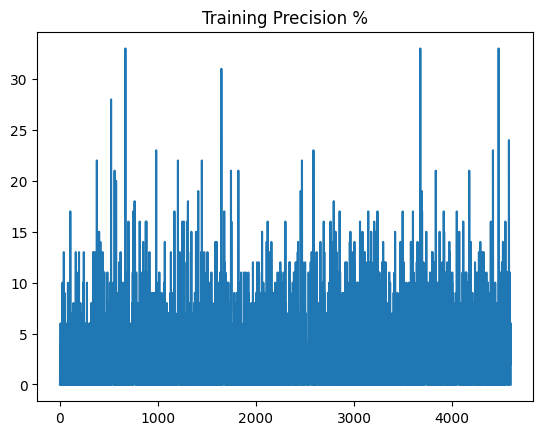

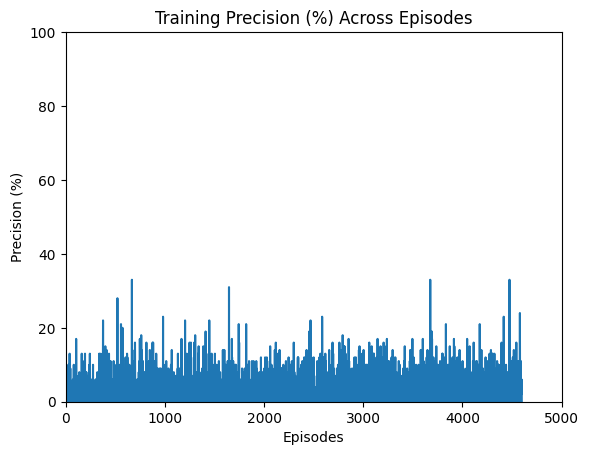

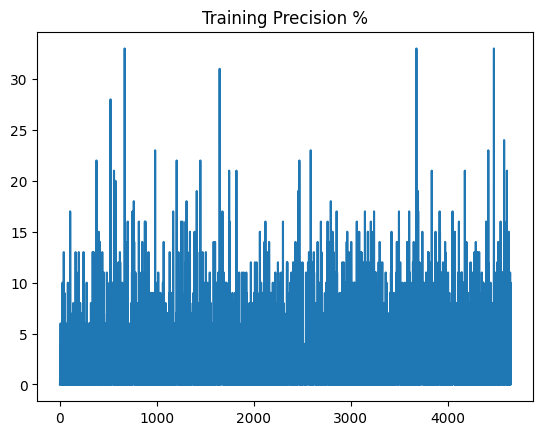

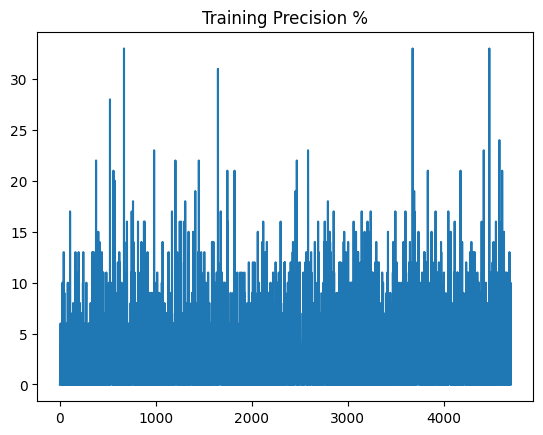

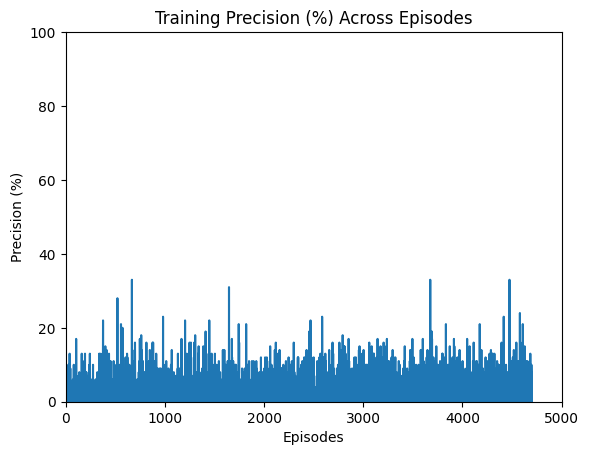

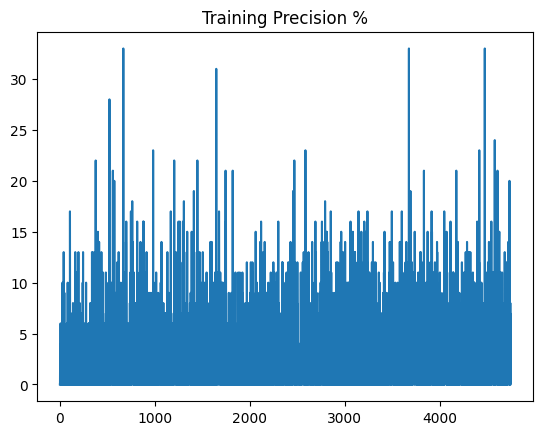

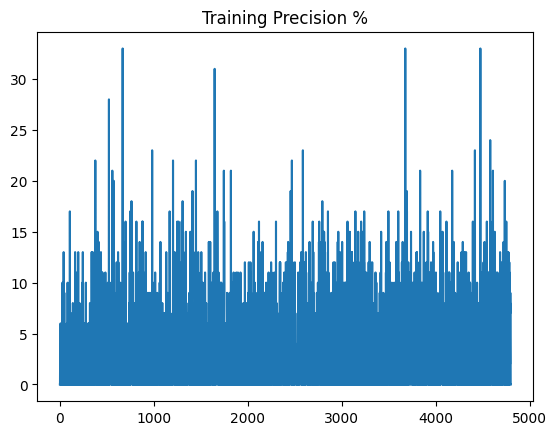

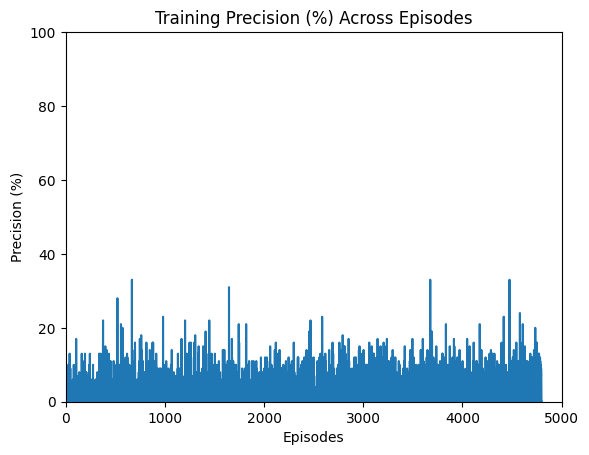

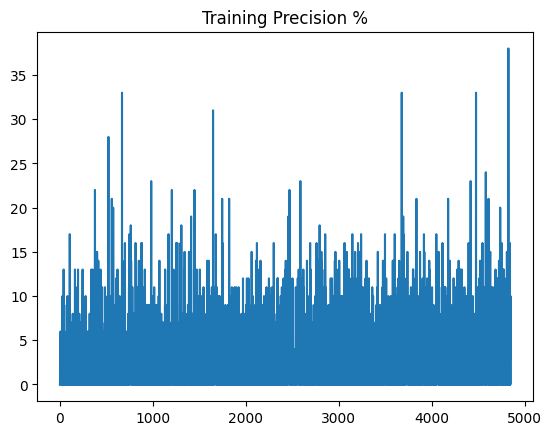

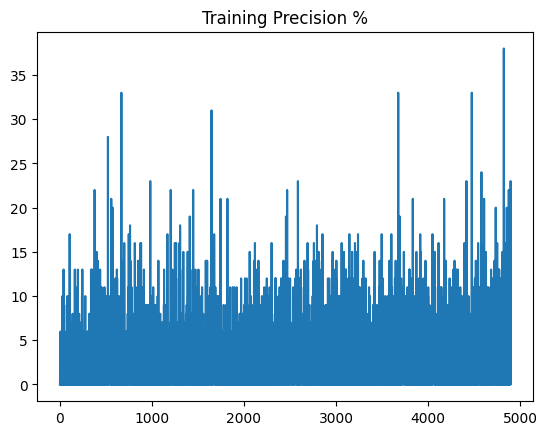

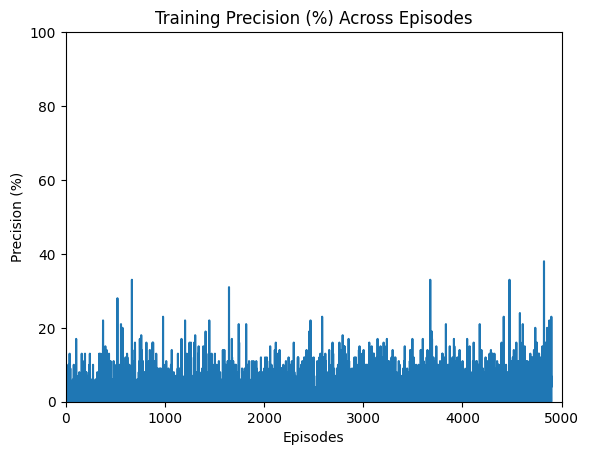

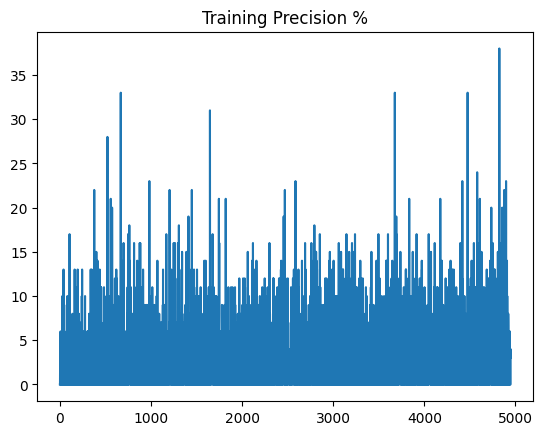

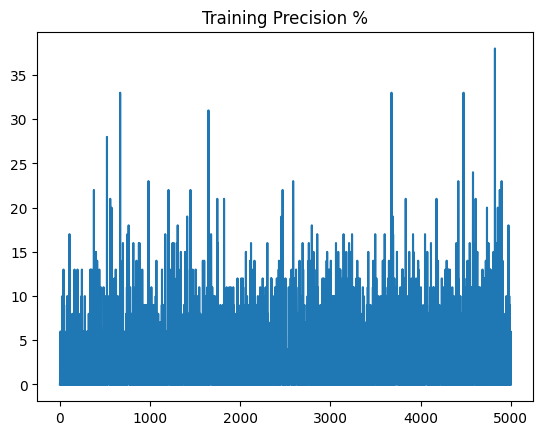

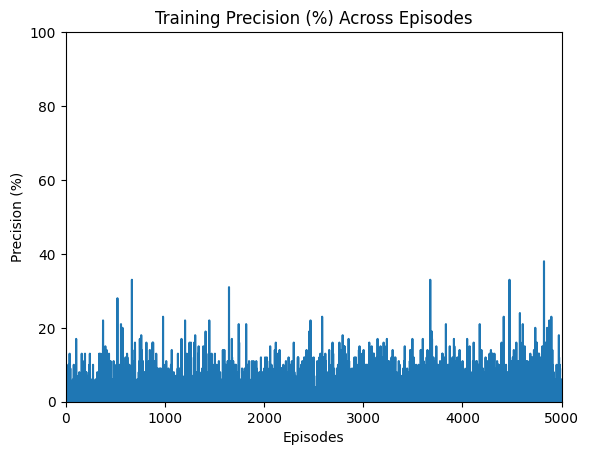

In [44]:
episodic_precision_history = []
episodic_reward_history = []
top_k = False

for episode in range(MAX_EPISODES_NUM):
    # episodic reward 리셋
    episode_reward = 0
    correct_count = 0
    steps = 0
    q_loss = 0
    mean_action = 0
    # Environment 리셋
    user_id, items_ids, done = env.reset()
    # print(f'user_id : {user_id}, rated_items_length:{len(env.user_items)}')
    # print('items : ', env.get_items_names(items_ids))
    while not done:
        
        # Observe current state & Find action
        ## Embedding 해주기
        user_eb = recommender.users_id_to_ebs[recommender.users_id_to_ebs["UserID"] == user_id]
        user_eb = user_eb.iloc[:, 1:].to_numpy()
        # user_eb = embedding_network.get_layer('user_embedding')(np.array(user_id))
        items_ebs = recommender.movies_id_to_ebs.loc[recommender.movies_id_to_ebs["MovieID"].isin(items_ids)]
        items_ebs = items_ebs.iloc[:, 1:]
        items_ebs = items_ebs.to_numpy()
        # items_eb = embedding_network.get_layer('movie_embedding')(np.array(items_ids))
        # items_eb = m_embedding_network.get_layer('movie_embedding')(np.array(items_ids))
        ## SRM으로 state 출력
        state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(items_ebs, axis=0)])

        ## Action(ranking score) 출력
        action = recommender.actor.network(state)

        ## ε-greedy exploration
        if recommender.epsilon > np.random.uniform() and not recommender.is_test:
            recommender.epsilon -= recommender.epsilon_decay
            action += np.random.normal(0,recommender.std,size=action.shape)

        ## Item 추천
        recommended_item = recommender.recommend_item(action, env.recommended_items, top_k=top_k)
        
        # Calculate reward & observe new state (in env)
        ## Step
        next_items_ids, reward, done, _ = env.step(recommended_item, top_k=top_k)
        if top_k:
            reward = np.sum(reward)

        # get next_state
        next_items_eb = recommender.movies_id_to_ebs.loc[recommender.movies_id_to_ebs["MovieID"].isin(items_ids)]
        next_items_eb = next_items_eb.iloc[:, 1:]
        next_items_eb = next_items_eb.to_numpy()
        # next_items_eb = embedding_network.get_layer('movie_embedding')(np.array(next_items_ids))
        # next_items_eb = m_embedding_network.get_layer('movie_embedding')(np.array(next_items_ids))
        next_state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(next_items_eb, axis=0)])

        # buffer에 저장
        recommender.buffer.append(state, action, reward, next_state, done)
        
        if recommender.buffer.crt_idx > 1 or recommender.buffer.is_full:
            # Sample a minibatch
            batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, weight_batch, index_batch = recommender.buffer.sample(recommender.batch_size)

            # Set TD targets
            target_next_action = recommender.actor.target_network(batch_next_states)
            qs = recommender.critic.network([target_next_action, batch_next_states])
            target_qs = recommender.critic.target_network([target_next_action, batch_next_states])
            min_qs = tf.raw_ops.Min(input=tf.concat([target_qs, qs], axis=1), axis=1, keep_dims=True) # Double Q method
            td_targets = recommender.calculate_td_target(batch_rewards, min_qs, batch_dones)

            # Update priority
            for (p, i) in zip(td_targets, index_batch):
                recommender.buffer.update_priority(abs(p[0]) + recommender.epsilon_for_priority, i)

            # print(weight_batch.shape)
            # print(td_targets.shape)
            # raise Exception
            # Update critic network
            q_loss += recommender.critic.train([batch_actions, batch_states], td_targets, weight_batch)
            
            # Update actor network
            s_grads = recommender.critic.dq_da([batch_actions, batch_states])
            recommender.actor.train(batch_states, s_grads)
            recommender.actor.update_target_network()
            recommender.critic.update_target_network()

        items_ids = next_items_ids
        episode_reward += reward
        mean_action += np.sum(action[0])/(len(action[0]))
        steps += 1

        if reward > 0:
            correct_count += 1
        
        print(f'recommended items : {len(env.recommended_items)},  epsilon : {recommender.epsilon:0.3f}, reward : {reward:+}', end='\r')

        if done:
            print()
            precision = int(correct_count/steps * 100)
            print(f'{episode+1}/{MAX_EPISODES_NUM}, precision : {precision:2}%, total_reward:{episode_reward}, q_loss : {q_loss/steps}, mean_action : {mean_action/steps}')
            if recommender.use_wandb:
                recommender.wandb.log({'precision':precision, 'total_reward':episode_reward, 'epsilone': recommender.epsilon, 'q_loss' : q_loss/steps, 'mean_action' : mean_action/steps})
            episodic_precision_history.append(precision)

    episodic_reward_history.append(episode_reward)
        
    if (episode+1)%50 == 0:
        plt.figure()
        plt.plot(episodic_precision_history)
        plt.title('Training Precision %')
        plt.savefig(os.path.join(save_model_weight_dir, f'images/training_precision_%_top_5.png'))

    if (episode+1)%100 == 0:
        plt.figure()
        plt.plot([i for i in range(episode+1)], episodic_precision_history)
        plt.title('Training Precision (%) Across Episodes')
        plt.xlabel('Episodes')
        plt.ylabel('Precision (%)')
        plt.ylim(0, 100)
        plt.xlim(0, MAX_EPISODES_NUM+1)
        plt.savefig(os.path.join(save_model_weight_dir, f'images/training_precision_%_across_episodes.png'))

    if (episode+1)%1000 == 0 or episode == MAX_EPISODES_NUM-1:
        recommender.save_model(os.path.join(save_model_weight_dir, f'actor_{episode+1}_fixed.h5'), os.path.join(save_model_weight_dir, f'critic_{episode+1}_fixed.h5'))

In [48]:
episodic_reward_mean_history = [np.mean(episodic_reward_history[i:i+100]) for i in range(0, len(episodic_reward_history), 100)]
episodic_reward_mean_history

[3.93,
 5.3,
 2.7,
 8.72,
 6.25,
 10.88,
 6.42,
 6.8,
 5.49,
 5.75,
 4.64,
 5.22,
 8.59,
 7.26,
 8.4,
 4.56,
 12.89,
 5.28,
 5.67,
 2.95,
 6.68,
 6.73,
 4.94,
 5.14,
 9.11,
 6.97,
 5.81,
 7.53,
 7.63,
 7.99,
 7.41,
 7.04,
 4.73,
 4.45,
 5.86,
 4.94,
 6.48,
 7.26,
 7.79,
 7.11,
 5.61,
 7.55,
 5.42,
 6.43,
 10.63,
 7.03,
 7.62,
 7.81,
 13.18,
 5.73]

In [54]:
# Converter a lista em uma série pandas (caso `episodic_reward_mean_history` seja uma lista)
reward_series = pd.Series(episodic_reward_mean_history)

# Calcular a média móvel com janela de 10 episódios (por exemplo)
window_size = 10
rolling_mean = reward_series.rolling(window=window_size).mean()


In [55]:
rolling_mean

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9     6.224
10    6.295
11    6.287
12    6.876
13    6.730
14    6.945
15    6.313
16    6.960
17    6.808
18    6.826
19    6.546
20    6.750
21    6.901
22    6.536
23    6.324
24    6.395
25    6.636
26    5.928
27    6.153
28    6.349
29    6.853
30    6.926
31    6.957
32    6.936
33    6.867
34    6.542
35    6.339
36    6.406
37    6.379
38    6.395
39    6.307
40    6.127
41    6.178
42    6.247
43    6.445
44    6.922
45    7.131
46    7.245
47    7.300
48    7.839
49    7.701
dtype: float64

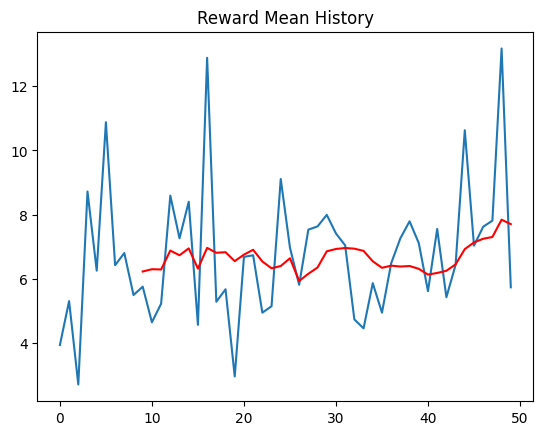

In [56]:
plt.figure()
plt.plot(episodic_reward_mean_history)
plt.plot(rolling_mean, label=f'Rolling Mean ({window_size} episodes)', color='red')
plt.title('Reward Mean History')
plt.show()

In [ ]:
recommender.movies_id_to_ebs.loc[recommender.movies_id_to_ebs["MovieID"].isin(items_ids)]

MovieID         0         1         2         3         4         5  \
33         34 -0.071559  0.141133 -0.006614  0.048649 -0.033094  0.052297   
437       441 -0.003469  0.184470 -0.026450  0.030462 -0.113089 -0.021985   
1221     1241 -0.003235  0.131031 -0.019480  0.004246 -0.076739  0.014352   
1302     1322 -0.124059  0.093513 -0.031145 -0.053689 -0.093409 -0.054106   
1450     1479  0.022815  0.170002 -0.039002  0.035750 -0.073463  0.063889   
2429     2498 -0.030514  0.059321 -0.036837  0.001079 -0.078944  0.059622   
2873     2942 -0.059692  0.182334 -0.046372  0.041721 -0.015146  0.026299   
3032     3101 -0.103831  0.106047 -0.027163 -0.004318 -0.040696  0.071640   
3045     3114 -0.105653  0.205682 -0.006230  0.032999  0.049154 -0.060259   
3493     3562 -0.073310  0.146389 -0.022057  0.077531 -0.110601  0.081520   

             6         7         8  ...       246       247       248  \
33   -0.002260  0.018882  0.004275  ... -0.045935 -0.001129 -0.043659   
437  -0.055245  0.067141 -0.060642  ...  0.022197 -0.013084  0.002962   
1221 -0.037322  0.048841 -0.008619  ... -0.026931 -0.025562 -0.081518   
1302 -0.026688  0.046809  0.010171  ... -0.004379  0.049493 -0.086998   
1450  0.030379 -0.009022 -0.026421  ... -0.002135  0.051246 -0.077023   
2429 -0.058719 -0.001843 -0.048556  ...  0.002374 -0.033575 -0.078593   
2873  0.043272  0.012815 -0.072829  ...  0.020506  0.019573 -0.014621   
3032  0.011033  0.031554 -0.049339  ...  0.033216  0.062720 -0.071806   
3045  0.007353  0.027231  0.038652  ...  0.056557  0.067547 -0.011930   
3493  0.087417  0.037985 -0.077068  ...  0.021320  0.049114 -0.111873   

           249       250       251       252       253       254       255  
33   -0.095606  0.115276  0.043571  0.007321  0.116093  0.060235 -0.006026  
437  -0.075845  0.171584 -0.009650 -0.008696  0.065446  0.030208  0.008386  
1221 -0.020917  0.118357  0.035201  0.091453  0.084526  0.036436 -0.025065  
1302  0.040919  0.182544  0.004903  0.070735  0.061717  0.004294  0.014348  
1450 -0.003609  0.035842 -0.019225  0.074568  0.121150  0.014783 -0.027633  
2429  0.019159  0.084515 -0.010062  0.069308  0.046624 -0.006882 -0.035909  
2873 -0.085702  0.098261 -0.011599  0.008085  0.030739  0.053045 -0.012690  
3032  0.005956  0.134636 -0.026304  0.070310  0.093913  0.017855 -0.032690  
3045 -0.002801  0.058623 -0.027346  0.009261  0.066170  0.005664  0.055266  
3493 -0.068165  0.106728  0.072327  0.008629 -0.008405  0.034660  0.040673  

[10 rows x 257 columns]

In [23]:
movies_id_to_ebs[movies_id_to_ebs["MovieID"] == 3897]

MovieID         0         1         2         3         4         5  \
3827     3897 -0.005195  0.162842 -0.023844 -0.000873 -0.076751 -0.053676   

             6         7         8  ...       246       247       248  \
3827 -0.078344  0.064499 -0.104056  ... -0.011709 -0.007424  0.042084   

           249       250       251      252       253       254       255  
3827 -0.031151  0.062412  0.031948  0.02269  0.074444  0.056973  0.041287  

[1 rows x 257 columns]

In [23]:
items = [data[0] for data in users_dict[6039][:STATE_SIZE]]
items

[111, 282, 2067, 1230, 930, 947, 3088, 3022, 3133, 1294]

In [24]:
recommended_items = set(items)
recommended_items

{111, 282, 930, 947, 1230, 1294, 2067, 3022, 3088, 3133}

In [25]:
items_ids = np.array(list(set(i for i in range(items_num)) - recommended_items))
items_ids

array([   0,    1,    2, ..., 3880, 3881, 3882])

In [31]:
user_eb = recommender.users_id_to_ebs[recommender.users_id_to_ebs["UserID"] == 6039]
user_eb = user_eb.iloc[:, 1:].to_numpy()
# user_eb = embedding_network.get_layer('user_embedding')(np.array(user_id))
items_ebs = recommender.movies_id_to_ebs.loc[items_ids]
items_ebs = items_ebs.iloc[:, 1:]
items_ebs = items_ebs.to_numpy()

In [32]:
state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(items_ebs, axis=0)])

In [33]:
state.shape

TensorShape([1, 768])

In [34]:
action = recommender.actor.network(state)

In [35]:
action.shape

TensorShape([1, 256])

In [36]:
if recommender.epsilon > np.random.uniform() and not recommender.is_test:
    recommender.epsilon -= recommender.epsilon_decay
    action += np.random.normal(0,recommender.std,size=action.shape)

In [37]:
action

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[-4.2997637 ,  2.1894164 , -3.7416453 , -2.4394252 ,  0.83338726,
        -1.2498598 , -0.49719226,  0.36360103,  0.33757603,  2.501947  ,
        -1.0608445 , -1.452625  ,  3.7263553 ,  0.8523555 , -2.1020305 ,
         1.598906  , -0.50545347,  2.689157  , -0.47797334,  0.608158  ,
         3.1938758 , -1.3970611 , -0.56426775, -0.90588427, -1.7631066 ,
         0.99688804,  0.44222152, -2.2589276 ,  0.3347155 ,  1.9850864 ,
         1.1040707 , -1.3088516 ,  0.7367896 , -3.0922155 ,  1.7830553 ,
        -1.6985312 , -0.35683173, -0.90784866,  0.27937186,  1.2216587 ,
        -1.3568792 , -0.7842497 , -2.3659015 ,  0.07576501,  2.2170186 ,
         2.3931315 , -2.982966  ,  0.88179255, -0.08156058,  2.3240638 ,
        -0.9107624 , -0.3303371 ,  1.136477  , -2.8944025 ,  0.29764724,
         0.85040253, -0.4284131 ,  0.3722521 ,  0.4145218 ,  3.2727914 ,
         1.6201111 , -1.8045801 , -0.8704196 , -0.8984232 ,  1.7127514 ,
 

In [38]:
action = tf.transpose(action, perm=(1,0))

In [39]:
action

<tf.Tensor: shape=(256, 1), dtype=float32, numpy=
array([[-4.2997637 ],
       [ 2.1894164 ],
       [-3.7416453 ],
       [-2.4394252 ],
       [ 0.83338726],
       [-1.2498598 ],
       [-0.49719226],
       [ 0.36360103],
       [ 0.33757603],
       [ 2.501947  ],
       [-1.0608445 ],
       [-1.452625  ],
       [ 3.7263553 ],
       [ 0.8523555 ],
       [-2.1020305 ],
       [ 1.598906  ],
       [-0.50545347],
       [ 2.689157  ],
       [-0.47797334],
       [ 0.608158  ],
       [ 3.1938758 ],
       [-1.3970611 ],
       [-0.56426775],
       [-0.90588427],
       [-1.7631066 ],
       [ 0.99688804],
       [ 0.44222152],
       [-2.2589276 ],
       [ 0.3347155 ],
       [ 1.9850864 ],
       [ 1.1040707 ],
       [-1.3088516 ],
       [ 0.7367896 ],
       [-3.0922155 ],
       [ 1.7830553 ],
       [-1.6985312 ],
       [-0.35683173],
       [-0.90784866],
       [ 0.27937186],
       [ 1.2216587 ],
       [-1.3568792 ],
       [-0.7842497 ],
       [-2.3659015 ],
    

In [40]:
items_ebs = tf.convert_to_tensor(items_ebs)

In [41]:
action = tf.cast(action, items_ebs.dtype)

In [42]:
action

<tf.Tensor: shape=(256, 1), dtype=float64, numpy=
array([[-4.29976368],
       [ 2.18941641],
       [-3.74164534],
       [-2.43942523],
       [ 0.83338726],
       [-1.24985981],
       [-0.49719226],
       [ 0.36360103],
       [ 0.33757603],
       [ 2.50194693],
       [-1.06084454],
       [-1.45262504],
       [ 3.72635531],
       [ 0.85235548],
       [-2.10203052],
       [ 1.59890604],
       [-0.50545347],
       [ 2.68915701],
       [-0.47797334],
       [ 0.60815799],
       [ 3.19387579],
       [-1.39706111],
       [-0.56426775],
       [-0.90588427],
       [-1.76310658],
       [ 0.99688804],
       [ 0.44222152],
       [-2.25892758],
       [ 0.33471549],
       [ 1.98508644],
       [ 1.10407066],
       [-1.3088516 ],
       [ 0.73678958],
       [-3.09221554],
       [ 1.78305531],
       [-1.69853115],
       [-0.35683173],
       [-0.90784866],
       [ 0.27937186],
       [ 1.22165871],
       [-1.35687923],
       [-0.78424972],
       [-2.36590147],
    

In [43]:
tf.keras.backend.dot(items_ebs, action)

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[3.85370639],
       [3.66724402],
       [1.14443659],
       [2.54042887],
       [2.78705968],
       [1.64342201],
       [1.74077205],
       [2.08127196],
       [2.19083195],
       [3.39454605]])>

In [44]:
item_idx = np.argmax(tf.keras.backend.dot(items_ebs, action))
item_idx

0

In [45]:
items_ids[item_idx]

1704

In [72]:
items_ebs = movies_id_to_ebs.loc[items_ids]
items_ebs = items_ebs.iloc[:, 1:]
a = items_ebs.to_numpy()
a.shape

(3873, 256)

In [73]:
b = np.expand_dims(items_ebs, axis=0)
b.shape

(1, 3873, 256)

In [74]:
c = tf.transpose(b, perm=(0,2,1))/recommender.embedding_dim
c.shape

TensorShape([1, 256, 3873])

In [75]:
wav = tf.keras.layers.Conv1D(1, 1, 1)

In [76]:
d = wav(c)
d.shape

TensorShape([1, 256, 1])

In [77]:
e = tf.transpose(d, perm=(0,2,1))
e.shape

TensorShape([1, 1, 256])

In [78]:
f = tf.squeeze(e, axis=1)
f.shape

TensorShape([1, 256])

In [79]:
g = np.expand_dims(user_eb, axis=0)
g.shape

(1, 1, 256)

In [80]:
h = tf.keras.layers.multiply([g, f])
h.shape

TensorShape([1, 1, 256])

In [45]:
user_eb = recommender.users_id_to_ebs[recommender.users_id_to_ebs["UserID"] == 6039]
user_eb = user_eb.iloc[:, 1:].to_numpy()

In [46]:
user_eb.shape

(1, 256)

In [51]:
f = np.expand_dims(user_eb, axis=0)
f.shape

(1, 1, 256)

In [52]:
tf.keras.layers.multiply([f, e])

ValueError: Inputs have incompatible shapes. Received shapes (1, 256) and (3873,)

In [21]:
users_id_to_ebs = pd.read_csv("./data/users_with_descriptions_and_embeddings_256.csv")
users_id_to_ebs.drop(columns=["Unnamed: 0", "Description_User"], inplace=True)

In [35]:
a = users_id_to_ebs[users_id_to_ebs["UserID"] == 6039]
a = a.iloc[:, 1:]
a = a.to_numpy()
a.shape

(1, 256)

In [40]:
items_ebs = movies_id_to_ebs.loc[items_ids]
items_ebs = items_ebs.iloc[:, 1:]
items_ebs = items_ebs.to_numpy()

In [41]:
items_ebs

(3873, 256)